<a href="https://colab.research.google.com/github/Xnretro/Colab-books/blob/main/ERP_Customer_Segmentation_%26_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 | Setup and Initialization

In [ ]:
# we're importing the libraries necesary
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [ ]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/DataSet/wwi_invoices_1.csv"
df = pd.read_csv(path,sep=";",header=0,names=["InvoiceLineId","InvoiceID","StockItemID","Description","Quantity","InvoiceDate","UnitPrice","CustomerId","Latitude","Longitude"],
                 parse_dates=["InvoiceDate"])
df.head(1)

,InvoiceLineId,InvoiceID,StockItemID,Description,Quantity,InvoiceDate,UnitPrice,CustomerId,Latitude,Longitude
0,2,2,50,Developer joke mug - old C developers never di...,9,2013-01-01,13.0,803,40.865731,-120.460226


In [ ]:
# realizamos una copia para ver posibles fallos
df_copy = df.copy()

# Step 2 | Initial Data Analysis

## Step 2.1

In [ ]:
df.head(10)

,InvoiceLineId,InvoiceID,StockItemID,Description,Quantity,InvoiceDate,UnitPrice,CustomerId,Latitude,Longitude
0,2,2,50,Developer joke mug - old C developers never di...,9,2013-01-01,13.0,803,40.865731,-120.460226
1,3,2,10,USB food flash drive - chocolate bar,9,2013-01-01,32.0,803,40.865731,-120.460226
2,4,3,114,Superhero action jacket (Blue) XXL,3,2013-01-01,30.0,105,33.484845,-89.360626
3,5,4,206,Permanent marker black 5mm nib (Black) 5mm,96,2013-01-01,2.7,57,41.020890,-81.435946
4,6,4,130,Furry gorilla with big eyes slippers (Black) S,5,2013-01-01,32.0,57,41.020890,-81.435946
5,7,4,50,Developer joke mug - old C developers never di...,2,2013-01-01,13.0,57,41.020890,-81.435946
6,8,5,128,Plush shark slippers (Gray) L,4,2013-01-01,32.0,905,45.784963,-93.556903
7,9,5,121,Dinosaur battery-powered slippers (Green) XL,3,2013-01-01,32.0,905,45.784963,-93.556903
8,10,5,155,Large sized bubblewrap roll 50m,20,2013-01-01,24.0,905,45.784963,-93.556903
9,11,6,150,Pack of 12 action figures (variety),4,2013-01-01,16.0,976,31.183565,-81.349818


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228264 entries, 0 to 228263
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceLineId  228264 non-null  int64         
 1   InvoiceID      228264 non-null  int64         
 2   StockItemID    228264 non-null  int64         
 3   Description    228264 non-null  object        
 4   Quantity       228264 non-null  int64         
 5   InvoiceDate    228264 non-null  datetime64[ns]
 6   UnitPrice      228264 non-null  float64       
 7   CustomerId     228264 non-null  int64         
 8   Latitude       228264 non-null  float64       
 9   Longitude      228264 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 17.4+ MB


Inferencia :

- **InvoiceLineId**: Es una columna de tipo int64 que reprsenta el id del detalle de la factura, no tiene datos nulos, recordemos que una factura puede estar representado por muchos detalles. lo que quire decir que cada registro puede pertenecer a una factura.
- **InvoiceID**: Es una columna del tipo int64, representa la cabecera de la factura o la factura.
- **StockItemId**: Es una columna del tipo int64, representa el codigo unico del producto. segun la base de datos este codigo representa a un unico producto, la variacion de cada producto como el color se presenta como otro codigo unico de producto.
- **Description**: La columna contiene el tipo de datos object (string), esta representa una description del producto, podemos usar este campo para hacer un *content-based filtering* ya que con la descripcion del producto podemos encontrar similitudes de uso (Debemos de tenerlo en cuenta) sin embargo eso sera cuando usemos la tabla, StockItem.
- **Quantity**: Esta columna es del tipo int64, registra la cantidad comprada por cada producto (Transacción)
- **InvoiceDate**: La columna contiene datos del tipo datetime64[ns], esta columna se refiere a la fecha en la que se genero la factura, debemos tener en cuenta la conversion de este tipo de dato, (object -> datetime64[ns])
- **UnitPrice** : El tipo de dato es float64, esta columna viene a representar el valor del precio unitario de cada producto en Stock. hay que tener en consideracion que este es el precio del producto si aplicar ningun tipo de descuento o aumento.
- **CustomerId**: Esta columna es del tipo int64 y viene a representar el id del cliente

Ninguna columna contiene valores nulos, la columna InvoiceDate fue convertida a datetime cuando obtenidos el dataframe para realizar posibles calulos, tambien vemos que diferentes clientes pueden tener diferentes transacciones.

Lo siguiente que haremos sera una limpieza de los datos, pre-procesamiento ver si encontramos valores atípicos y crear nuevas características (columnas) que nos pueden ayudar a alcanzar nuestro objetivo.

## Step 2.2 | Summary Statistics

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
InvoiceLineId,228264.0,114133.5,2.0,57067.75,114133.5,171199.25,228265.0,65894.285261
InvoiceID,228264.0,35179.363798,2.0,17572.0,35152.0,52765.0,70510.0,20337.119712
StockItemID,228264.0,110.181474,1.0,54.0,111.0,165.0,227.0,63.729111
Quantity,228264.0,39.211693,1.0,5.0,10.0,60.0,360.0,54.558914
InvoiceDate,228264,2014-10-08 12:26:39.579434752,2013-01-01 00:00:00,2013-12-06 00:00:00,2014-10-23 00:00:00,2015-08-11 00:00:00,2016-05-31 00:00:00,NaN
UnitPrice,228264.0,45.590881,0.66,13.0,18.0,32.0,1899.0,139.861829
CustomerId,228264.0,528.711054,1.0,160.0,518.0,877.0,1061.0,343.722635
Latitude,228264.0,38.568977,17.994133,34.474818,39.202503,42.162891,65.209722,6.154459
Longitude,228264.0,-92.675106,-166.208056,-100.978195,-89.968702,-80.075875,-65.797939,16.842193


In [ ]:
# Resumen estadistico para variables categoricas
df.describe(include="object").T

,count,unique,top,freq
Description,228264,227,Dinosaur battery-powered slippers (Green) L,1123


Inferencias:

- *InvoiceLineId, InvoiceId, StockItemId* representan Ids por lo que no podemos hacer ninguna inferencia.

- Quantity:
  - La cantidad promedio de productos en una transacion es aprox 39.2
  - La cantidad tiene un rango entre 1 - 360
  - Tenemos una desviacion standard de 54.6 lo que indica que tenemos una gran dispercion en el tamaño (cantidad) de los pedidos  
  - La presencia de outliers se indica mediante una gran diferencia entre el valor maximo y el valor de 75th percentile, en nuestro caso el valor nos es tan cosiderable, pero para mayor seguridad haremos un analisis con grafico de caja y un histograma.


- UnitPrice
  - El precio promedio de los productos es aproximadamente 45.5
  - El rango del precio de los producto varia de 0.66	 hasta 1899.0 es bueno no encontra valores nulos o negativos los cuales pueden indicar ruido o comportamientos extraños.
  - La presencia de outliers se indica en una gran diferencia entre el valor maximo y el 75th percentile en nuestro caso: 1899.0 y 32.0 los cual indica la presencia de outliers, pero debemos tener en cuenta que en nuestro contexto los precios de los productos varian bastante.


- Description:
  - Hay 227 unicos valores en la columna descripcion.
  - La descripcion del producto mas frequente es "Dinosaur battery-powered slippers (Green) L" apareciendo 1123

# Step 3 | Data Cleaning & Transformation

## Step 3.1 | Handling Missing Values

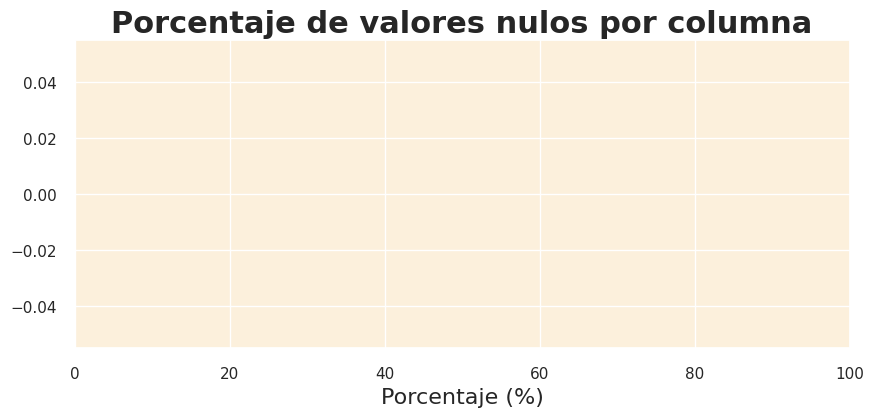

In [ ]:
# Calculamos el porcentaje de valores nulos por columna
missing_data = df.isnull().sum()
missing_data_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Preparamos los valores
missing_data.sort_values(ascending=True,inplace=True)

# Graficamos un grafico de barra horizontal
fig,ax = plt.subplots(figsize=(10,4))
ax.barh(missing_data_percentage.index,missing_data_percentage,color="#ff6200")

# Anotamos los valores y los indices
for i,(value,name) in enumerate(zip(missing_data_percentage,missing_data_percentage.index)):
  ax.text(value+0.5,i,f"{value:.2f}%",ha="lef",va="center",fontweight="bold",fontsize=18,color="black")

# cambiar el limite de x-axis
ax.set_xlim([0, 100])

# Añadir titulo y xlabel
plt.title("Porcentaje de valores nulos por columna",fontweight="bold",fontsize=22)
plt.xlabel("Porcentaje (%)",fontsize=16)
plt.show()

- Como mencione antes no existen valores nulos, y esto es importante ya que la columna CustomerID es esencial para hacer clustering y poder diseñar un sistema de recomendación.
- Una gran cantidad de valores nulos crearian un sesgo y ruido dentro del analisis.
- Ya que el clustering se basa en el comportamiento y preferencias de los clientes es crucial tener una presicion sobre los indentificadores de los clientes. por lo que si tuvieras valores nulos dentro de los Identificadores la mejor opcion seria removerlos, para mantener la integridad de los clusters y el analisis.  
- A pesar de que nuestros datos no tengan valores nulos dentro de Customer ID pueden haber problemas en la extracion de datos (Producion), para estar seguros y no generar posibles errores vamos a considerar eliminar registros con valores nulos en los Ids de los Clientes

In [ ]:
df.columns

Index(['InvoiceLineId', 'InvoiceID', 'StockItemID', 'Description', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerId', 'Latitude', 'Longitude'],
      dtype='object')

In [ ]:
# Removiendo filas con valores nulos dentro de la columna CustomerID (Mover con Feature-Engine Pipeline)
df = df.dropna(subset=["CustomerId"])

In [ ]:
# Verificando que las columnas no tengan valores nulos (Mover con Feature-Engine Pipeline)
df.isnull().sum().sum()

np.int64(0)

## Step 3.2 | Handling Duplicates

In [ ]:
# Encontra todos los registros duplicados pero mantenerlos
duplicated_rows = df[df.duplicated(keep=False)]

# Orderar los datos por ciertas columnas para ver una a lado de otro registrod duplicados.
duplicated_rows_sorted = duplicated_rows.sort_values(by=['InvoiceLineId', "InvoiceID",'StockItemID', 'Description', 'CustomerId', 'Quantity'])

# Mostrar los primero 10 registros
duplicated_rows_sorted.head(10)


,InvoiceLineId,InvoiceID,StockItemID,Description,Quantity,InvoiceDate,UnitPrice,CustomerId,Latitude,Longitude


Inference:

- No vemos registro duplicados, y tiene mucho sentido ya que cada id se genera de manera automatica desde la base de datos, y viene hacer unico.
- En este escenario no vamos a remover filas, sin embargo esta funcion podria incluirse dentro de producción para asegurar el correcto funcionamiento

In [ ]:
# Mostrando el numero de filas duplicadas
print(f"Este dataset contiene {df.duplicated().sum()} filas duplicadas las cuales seran removidas")

Este dataset contiene 0 filas duplicadas las cuales seran removidas


In [ ]:
# removiendo filas duplicadas -> (Generar Feature-Engine)
df.drop_duplicates(inplace=True)

## Step 3.3 | Treating Cancelled Transactions

Necesito conseguir la manera de medir si una transacciones, fue exitosa, o si se hiso algun cambio en la cantidad del producto o el producto.

- De esta manera podemos ver si una transaccion se cancelo
- Si se hizo un aumento o disminución en la cantidad del producto.
- Es imperativo entender, los patrones de cancelacion

## Step 3.4 | Correcting StockCode Anomalies

In [ ]:
# Encontrando el numero de codigos unicos.
unique_stock_codes = df["StockItemID"].nunique()

# Imprimiendo el numero de unicos codigos de Stock
print(f"El numero unico de codigos de productos: {unique_stock_codes}")

El numero unico de codigos de productos: 227


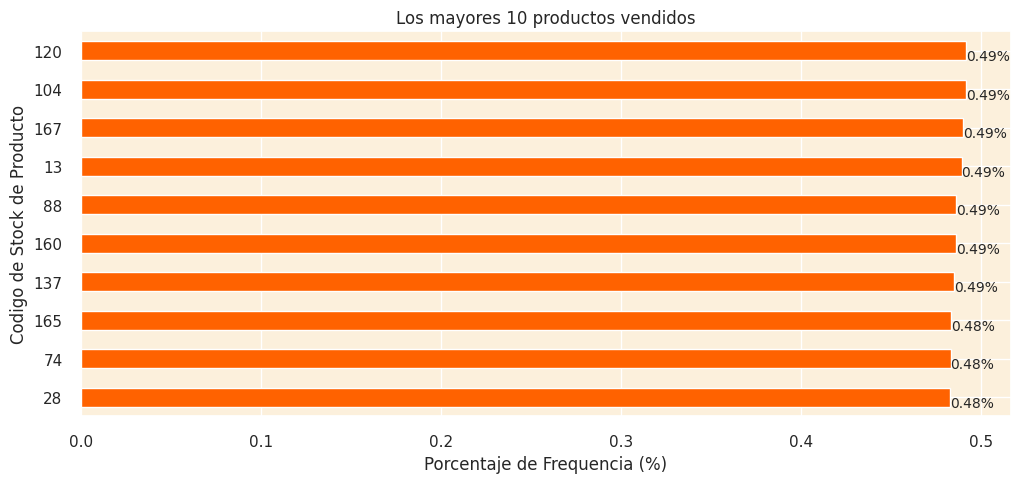

In [ ]:
# Encontrando los 10 mejores productos
top_10_stock_codes = df["StockItemID"].value_counts(normalize=True).sort_values(ascending=False).head(10) * 100

# Graficando los 10 mejores stock codes.
plt.figure(figsize=(12,5))
top_10_stock_codes.plot(kind="barh",color="#ff6200")

# Agregando porcentaje de frecuencias de los bars
for index,value in enumerate(top_10_stock_codes):
  plt.text(value,index+0.25, f'{value:.2f}%',fontsize=10)

plt.title('Los mayores 10 productos vendidos')
plt.xlabel('Porcentaje de Frequencia (%)')
plt.ylabel('Codigo de Stock de Producto')
plt.gca().invert_yaxis()
plt.show()


Inferencia de Codigos de Stock :

- La variedad del producto: El dataset contiene 227 productos unicos.La diversidad nos lleva a indentificar disntintos cluster de clientes, con preferencias de distintos tipos de productos.
- Items Populares: Dando un pequeño vistazo a los 10 mayores items.   

## Step 3.5 | Description Column

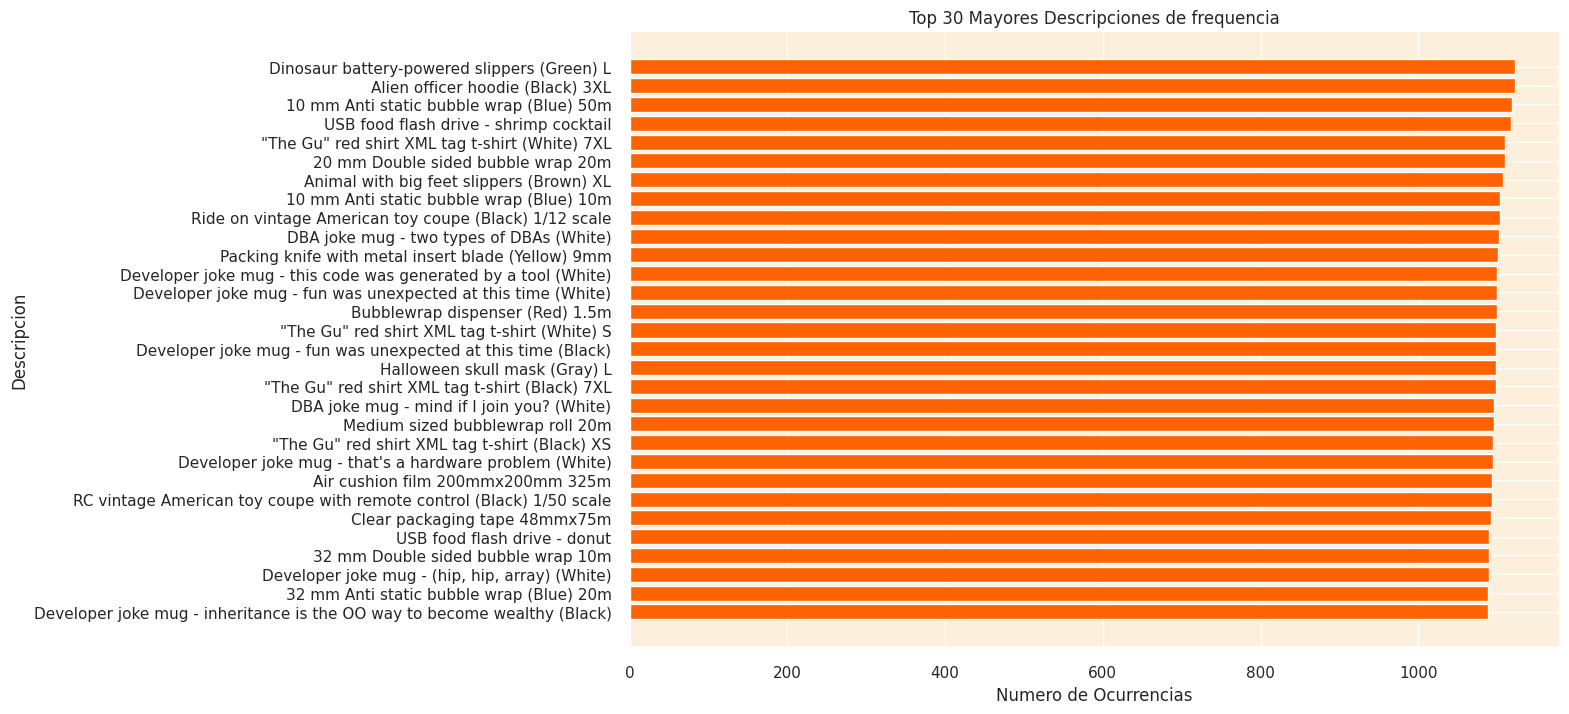

In [ ]:
# Calculando las ocurrencias de cada unica descripcion y ordenarlos
description_counts = df['Description'].value_counts()

# Obtener los top 30 mejores descripcion
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Numero de Ocurrencias')
plt.ylabel('Descripcion')
plt.title('Top 30 Mayores Descripciones de frequencia')

# Show the plot
plt.show()

## Step 3.5 | Analisys Price Column

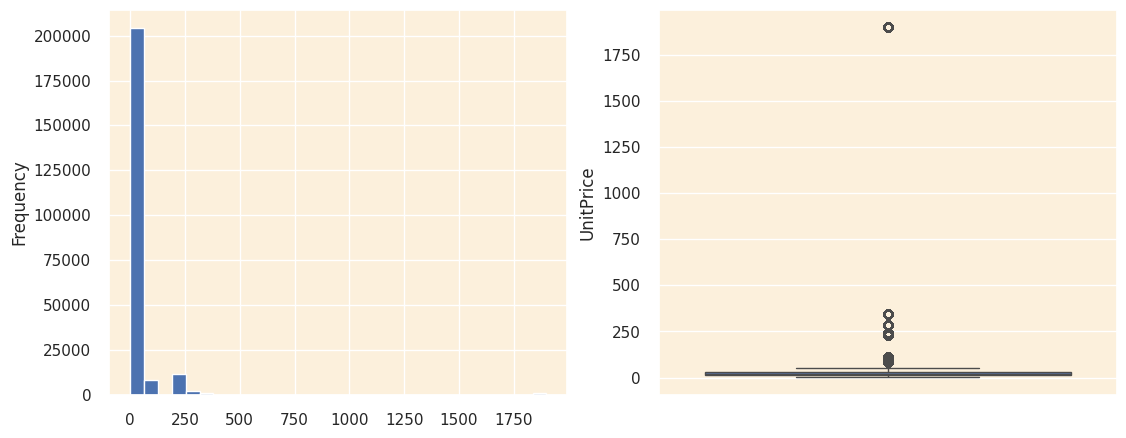

In [ ]:
# Creamos box-plot
fig,axes = plt.subplots(1,2,figsize=(13,5))

# creamos el histograma para UnitPrice
df["UnitPrice"].plot(kind="hist",bins=30,ax=axes[0])

# Creamos box-plot
sns.boxplot(df["UnitPrice"],ax=axes[1])
plt.show()

Inferencia

- El grafico de histograma y el box-plot muestran que tenemos outliers dentro de UnitPrice, estos datos pueden ser un problema si usamos algoritmos de clustering, (K means por que se basa en distancias) - Hay que verificar la cantidad de registros outliers,para ver el procedimiento a seguir.
- Para detectar outliers debemos usar quartiles para calcular outliers, porque los datos no siguen una distribucion normal y se encuentran sesgados a la derecha. los precios mayores, tienden a ser muy ratos debemos considerar usar la cola derecha para detectar outliers.
- Cuando hablamos de precios debemos considerar los outliers que se encuentran en la parte derecha de la cola ya que estos representan valores (precios) mas altos. y revisando la grafica podemos ver que existe un sesgo muy grande a valores mas grandes.

In [ ]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 4.5 MB/s eta 0:00:00


In [ ]:
# Usamos feature engine para capturar esos valores atipicos,usamas tail = (right)
# para detectar esos valores que se encuentran en la cola derecha y son cosiderados outlieres
#
from feature_engine.outliers import Winsorizer,OutlierTrimmer
#
ott = OutlierTrimmer(
    capping_method="iqr",
    tail="right",
    fold=3,
    variables=["UnitPrice"],
)
df_transformd_test = ott.fit_transform(df)

<Axes: ylabel='Frequency'>

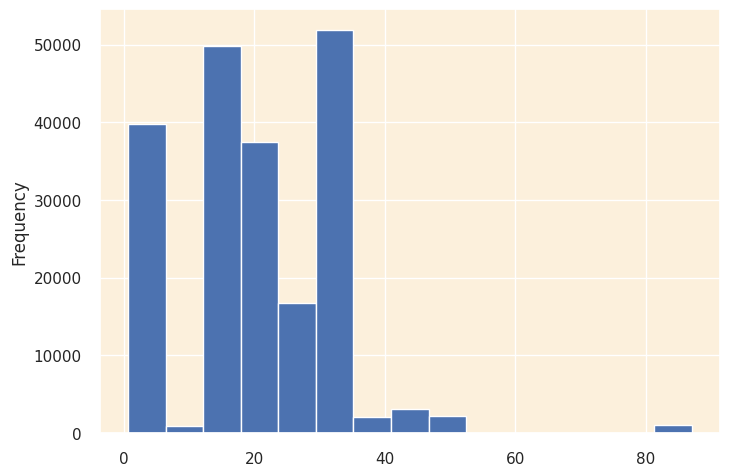

In [ ]:
df_transformd_test["UnitPrice"].plot(kind="hist",bins=15)

In [ ]:
df_transformd_test["UnitPrice"].min(),df_transformd_test["UnitPrice"].max()

(0.66, 87.0)

In [ ]:
df["UnitPrice"].min(),df["UnitPrice"].max()

(0.66, 1899.0)

In [ ]:
df.shape

(228264, 10)

In [ ]:
df_transformd_test.shape

(205165, 10)

Inference:

- Si recortamos outliers con fold = 3 vemos que tenemos una mejor representación de la distribución, y que puede ayudar al algoritmo de clustering, sin embargo tenemos que analizar los productos con los precios que son clasificados como outliers, y ver si conservamos o eliminamos esos registros.
- se elimino aproximadamenet 23,099 registros con productos marcados como outliers.
- Hay que analizar la parte que eliminados.

In [ ]:
# Calculamos los valores que se son considerados outliers y se encuentran en la cola superior
# Quartile 1 y 3
q1 = df["UnitPrice"].quantile(0.25)
q3 = df["UnitPrice"].quantile(0.75)

#Calcula el Rango Intercuartílico (IQR):
iqr = q3 - q1

#Asignamos un fold = 3 o 1.5 en nuestro caso 3
fold = 3

#Determina los límites
li = q1 - (fold*iqr)
ls = q3 + (fold*iqr)

#Ahora que tenemos el limite superior vamos a detectar todos aquellos registros que fueron eliminados

In [ ]:
# dataframe with outliers
df_outliers = df[df["UnitPrice"] > ls]

# cantidad de productos
df_outliers_counts =  (df_outliers["StockItemID"].value_counts())

# ....
for index,value in enumerate(zip(df_outliers_counts.index,df_outliers_counts.values)):
  print(index,value)
  print(value[0])
  price_out = df_outliers[df_outliers["StockItemID"] == value[0]]["UnitPrice"].head(1).values[0]
  print(price_out)

0 (167, np.int64(1119))
167
99.0
1 (74, np.int64(1103))
74
285.0
2 (176, np.int64(1100))
176
240.0
3 (214, np.int64(1094))
214
90.0
4 (173, np.int64(1085))
173
105.0
5 (69, np.int64(1069))
69
230.0
6 (71, np.int64(1063))
71
230.0
7 (215, np.int64(1061))
215
1899.0
8 (161, np.int64(1059))
161
108.0
9 (72, np.int64(1057))
72
230.0
10 (67, np.int64(1044))
67
230.0
11 (75, np.int64(1043))
75
345.0
12 (70, np.int64(1041))
70
230.0
13 (158, np.int64(1035))
158
105.0
14 (170, np.int64(1033))
170
102.0
15 (68, np.int64(1032))
68
230.0
16 (15, np.int64(1022))
15
240.0
17 (73, np.int64(1020))
73
285.0
18 (174, np.int64(1019))
174
240.0
19 (175, np.int64(1019))
175
240.0
20 (164, np.int64(1004))
164
112.0
21 (8, np.int64(977))
8
240.0


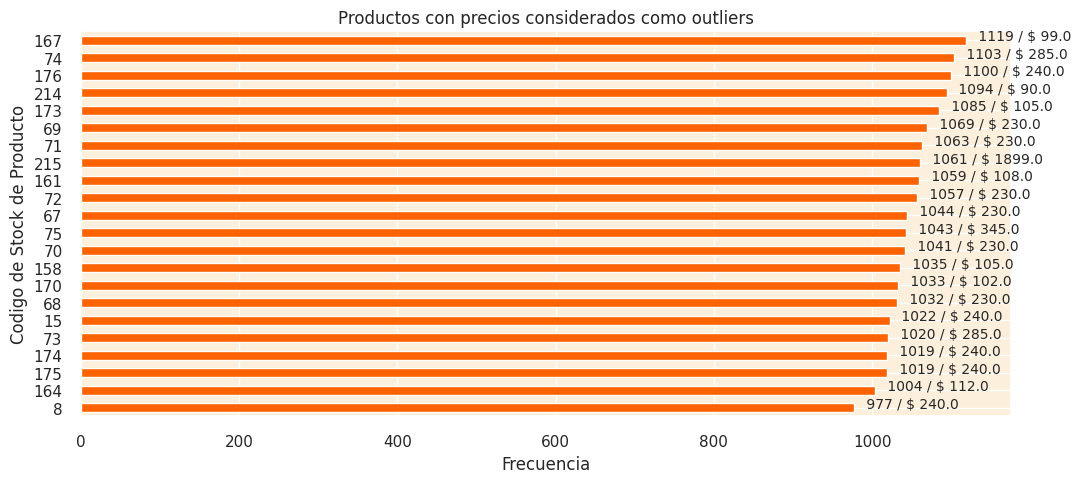

In [ ]:
# dataframe with outliers
df_outliers = df[df["UnitPrice"] > ls]

# cantidad de productos
df_outliers_counts = (df_outliers["StockItemID"].value_counts())

# Graficando stock codes
plt.figure(figsize=(12,5))
df_outliers_counts.plot(kind="barh",color="#ff6200")

# ....
for index,value in enumerate(zip(df_outliers_counts.index,df_outliers_counts.values)):
  #print(index,value)
  #print(value[0])
  price_out = df_outliers[df_outliers["StockItemID"] == value[0]]["UnitPrice"].head(1).values[0]
  #print(price_out)
  plt.text(value[1] + 10,index, f' {value[1]} / $ {price_out}',fontsize=10)

# Agregando porcentaje de frecuencias de los bars
# for index,value in enumerate(top_10_stock_codes):
#   plt.text(value,index+0.25, f'{value:.2f}%',fontsize=10)

plt.title('Productos con precios considerados como outliers')
plt.xlabel('Frecuencia')
plt.ylabel('Codigo de Stock de Producto')
plt.gca().invert_yaxis()
plt.show()


Inference:
- Cada producto considerado como outliers, se encuentra en un promedio de 1000 registros. lo que indica que a pesar de que el precio se considera no muy comun, dentro del estandar de venta de mis productos, estos productos se encuentran en diferentes transacciones echas por los clientes, claro que comparado con los otros productos, y sus precios si existen una gran diferencia.
- Podemos considerar que hay un patron, debido a que si consideraramos solo ruido estos productos no se encontrarian en muchas transacciones. Si tomamos como ejemplo el producto con codigo 215 se encuentro en 1061 transacciones a pesar de su elevado precio unitario de 1899.0
- Puede ser que estos productos compartan algunos caracteristicas en comun pero eso lo analizaremos cuando hagamos content-base filtering

Strategia:

- Podemos usar K-Medoids (PAM, CLARA) : parecido a K-Means, pero usa medianas en vez de medias. Mucho más robusto a outliers.

- DBSCAN o HDBSCAN : no necesitan definir el número de clusters y detectan “densidades”. Los outliers se marcan como ruido o incluso se forman en su propio cluster.

- Gaussian Mixture Models (GMM) : más flexible, modela distribuciones probabilísticas y puede capturar subgrupos con distintas varianzas.

Transformar variables (reducir impacto)

- Escalado robusto : usar RobustScaler en lugar de StandardScaler (usa medianas y rango intercuartílico).

- Log/Box-Cox transform : si los precios tienen una distribución muy sesgada (cola larga), transformar ayuda a reducir la distorsión.

## Step 3.6 | Analisys Quantity Column

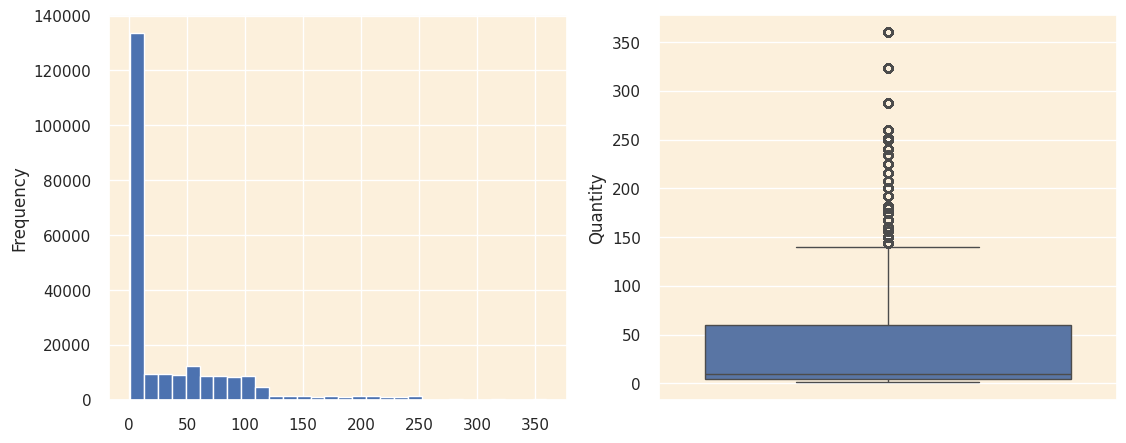

In [ ]:
# Creamos box-plot
fig,axes = plt.subplots(1,2,figsize=(13,5))

# creamos el histograma para Quantity
df["Quantity"].plot(kind="hist",bins=30,ax=axes[0])

# Creamos box-plot
sns.boxplot(df["Quantity"],ax=axes[1])
plt.show()

Inferencia

- El grafico de histograma y el box-plot muestran que tenemos outliers dentro de Quantity, estos datos pueden ser un problema si usamos algoritmos de clustering, (K means por que se basa en distancias) - Hay que verificar la cantidad de registros outliers,para ver el procedimiento a seguir.
- Para detectar outliers debemos usar quartiles para calcular outliers, porque los datos no siguen una distribucion normal y se encuentran sesgados a la derecha. los precios mayores, tienden a ser muy ratos debemos considerar usar la cola derecha para detectar outliers.
- Cuando hablamos de precios debemos considerar los outliers que se encuentran en la parte derecha de la cola ya que estos representan valores (cantidades) mas altos. y revisando la grafica podemos ver que existe un sesgo muy grande a valores mas grandes.

In [ ]:
# Calculamos los valores que se son considerados outliers y se encuentran en la cola superior
# Quartile 1 y 3
q1 = df["Quantity"].quantile(0.25)
q3 = df["Quantity"].quantile(0.75)

#Calcula el Rango Intercuartílico (IQR):
iqr = q3 - q1

#Asignamos un fold = 3 o 1.5 en nuestro caso 3
fold = 3

#Determina los límites
li = q1 - (fold*iqr)
ls = q3 + (fold*iqr)


In [ ]:
# dataframe with outliers
df_outliers = df[df["Quantity"] > ls]

# cantidad de productos
df_outliers_counts =  (df_outliers["StockItemID"].value_counts())

# ....
for index,value in enumerate(zip(df_outliers_counts.index,df_outliers_counts.values)):
  print(index,value)
  print(value[0])
  price_out = df_outliers[df_outliers["StockItemID"] == value[0]]["Quantity"].head(1).values[0]
  print(price_out)

0 (191, np.int64(428))
191
288
1 (192, np.int64(383))
192
288
2 (189, np.int64(235))
189
234
3 (198, np.int64(132))
198
240
4 (188, np.int64(124))
188
250
5 (177, np.int64(119))
177
250
6 (201, np.int64(118))
201
240
7 (196, np.int64(116))
196
240
8 (185, np.int64(116))
185
250
9 (199, np.int64(115))
199
240
10 (186, np.int64(114))
186
250
11 (183, np.int64(112))
183
250
12 (200, np.int64(110))
200
240
13 (194, np.int64(107))
194
240
14 (197, np.int64(105))
197
240
15 (178, np.int64(103))
178
250
16 (180, np.int64(103))
180
250
17 (195, np.int64(103))
195
240
18 (182, np.int64(102))
182
250
19 (187, np.int64(100))
187
250
20 (179, np.int64(99))
179
250
21 (181, np.int64(95))
181
250
22 (202, np.int64(83))
202
240
23 (184, np.int64(66))
184
250
24 (193, np.int64(18))
193
240
25 (220, np.int64(14))
220
240
26 (226, np.int64(13))
226
240
27 (223, np.int64(11))
223
240
28 (222, np.int64(11))
222
240
29 (227, np.int64(10))
227
240
30 (225, np.int64(10))
225
240
31 (224, np.int64(8))
224
240

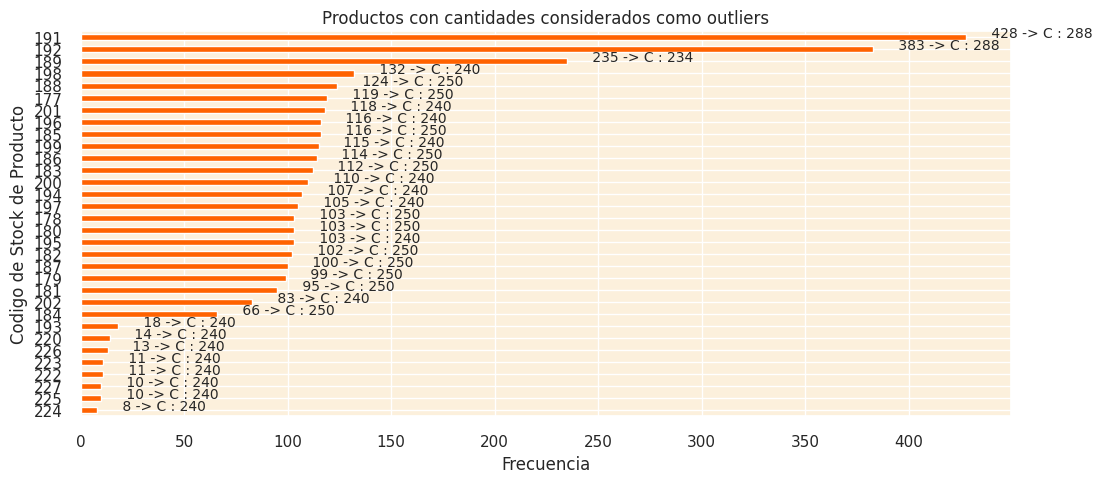

In [ ]:
# dataframe with outliers
df_outliers = df[df["Quantity"] > ls]

# cantidad de productos
df_outliers_counts = (df_outliers["StockItemID"].value_counts())

# Graficando stock codes
plt.figure(figsize=(12,5))
df_outliers_counts.plot(kind="barh",color="#ff6200")

# ....
for index,value in enumerate(zip(df_outliers_counts.index,df_outliers_counts.values)):
  #print(index,value)
  #print(value[0])
  quantity_out = df_outliers[df_outliers["StockItemID"] == value[0]]["Quantity"].head(1).values[0]
  #print(price_out)
  plt.text(value[1] + 10,index, f' {value[1]} -> C : {quantity_out}',fontsize=10)

# Agregando porcentaje de frecuencias de los bars
# for index,value in enumerate(top_10_stock_codes):
#   plt.text(value,index+0.25, f'{value:.2f}%',fontsize=10)

plt.title('Productos con cantidades considerados como outliers')
plt.xlabel('Frecuencia')
plt.ylabel('Codigo de Stock de Producto')
plt.gca().invert_yaxis()
plt.show()

Inferencia:

- En el caso de la cantidad vendida por producto tenemos existen pocos registros, con cantidad consideradas como outliers, para ciertos productos.
- Analizando el rango de la cantidad considerada con outliers va desde 240 - 288 lo cual indica que la variacion no es tan grande como el precio del producto.
- Algo que podemos observar es que ha medida que la cantidad de productos que se comprar para cierto producto la cantidad de registros tambien aumenta. un ejemplo claro son los productos 191,192 y 189 que muestran

# Step 4 | Feature Engineering

Para crear un dataset que nos ayude ha realizar clustering y recomendaciones, necesitamos las siguientes caracteristicas puedes ser generadas para los datos disponibles.


Step 4.1 | RFM Features

RFM es un metodo usado para analizar el valor de los clientes y segmentar la base de los clientes.
- Recency (R) : Esta metrica indica que tan recientemente un cliente (customer) ha hecho una compra, un bajo recency indica que el cliente ha comprado recientemente, y tiene un mayor compromiso con la marca
- Frequency (F): Esta metrica indica que tan a menudo un cliente (customer) hace un compra dentro de cierto periodo, una frecuencia mas alta indica que un cliente interactua con el negocio mas menudo, sugeriendonos mayor lealtad or satisfacion.
- Monetary (M) : Esta metrica indica el total de la cantidad de dinero, que un cliente ha gastado sobre cierto periodo. Clientes que tiene un mayor valor en monetary han contribuido mas al negocio,lo que indica su potencial alto valor de vida útil.

Juntos estas metricas nos ayudan a entender el comportamiento de compra del cliente y sus preferencias, lo cual es fundamental para personalizar las estrategias de marketing y crear un sistema de recomendaciones.

### Step 4.1.1 | Recency (R)

In [ ]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerId')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [ ]:
customer_data

,CustomerId,Days_Since_Last_Purchase
0,1,4
1,2,17
2,3,1
3,4,33
4,5,3
...,...,...
658,1057,4
659,1058,5
660,1059,1
661,1060,7


Ahora tenemos el dataframe customer_data el cual contiene "Days_Since_Last_Purchase" dias hasta la ultima compra.

In [ ]:
customer_data.head()

,CustomerId,Days_Since_Last_Purchase
0,1,4
1,2,17
2,3,1
3,4,33
4,5,3


### Step 4.1.2 | Frequency (F)

Voy a crear dos funciones que cuantifiquen la frecuencia de interacción de un cliente:
- Total de Transacciones: Esta caracteristica representa el numero total de transacciones hechas por un cliente (customer) y nos ayuda a entender el nivel de compromiso de un cliente.
- Total de productos comprados: Esta caracteristica nos indica el numero total de productos (suma de cantidades) compradas por un cliente atravez de todas las transaccinones (registros), esto nos da un insight del comportarmiento de compra de los clientes, in terminos de volumen de productos comprados.

Estas características serán cruciales para segmentar a los clientes en función de su frecuencia de compra, lo que es un aspecto clave para determinar segmentos de clientes para marketing dirigido y recomendaciones personalizadas.

- Para esto nos vamos a ayudar de InvoiceID el cual es el id de factura o encabezado de la factura, en cual contiene las diferentes transacciones echas por el cliente, (detalle de la factura) los detalles estan representados por InvoiceLineID

In [ ]:
df.head(1)

,InvoiceLineId,InvoiceID,StockItemID,Description,Quantity,InvoiceDate,UnitPrice,CustomerId,Latitude,Longitude,InvoiceDay
0,2,2,50,Developer joke mug - old C developers never di...,9,2013-01-01,13.0,803,40.865731,-120.460226,2013-01-01


In [ ]:
# Calculamos el numero total de transaccinoes echas por cada cliente,
total_transactions = df.groupby('CustomerId')['InvoiceID'].count().reset_index()
total_transactions.rename(columns={'InvoiceID': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerId')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerId')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerId')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerId,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,1,4,406,17327
1,2,17,361,14693
2,3,1,437,15874
3,4,33,316,13571
4,5,3,384,15480


In [ ]:
#customer_data.drop(columns=["Total_Transactions_x","Total_Products_Purchased_x","Total_Transactions_y","Total_Products_Purchased_y"],inplace=True)

### Step 4.1.3 | Monetary (M)

Voy a crear dos caracteristicas que representan el aspecto monetario de las transacciones de cada cliente.
- Total gastado: esta caracteristica representa la cantidad total de dinero gastada por cada cliente, esto se calcula como la suma del producto unitario y la cantidad por todas las transacciones echas por un cliente, esta caracteristica es crucial, ayuda a indentificar ingresos totales generados por cada cliente, el cual es un indicador directo del valor del cliente para el negocio.
- Valor Promedio Transaccional: Esta caracteristica se calcula como el Total gastado entre el total de transacciones echas por cada cliente. este indica el valor promedio de una transaccion realizado por un cliente, Esta métrica es útil para comprender el comportamiento de gasto de los clientes por transacción, que puede ayudar a adaptar las estrategias de marketing y las ofertas a diferentes segmentos de clientes en función de sus patrones de gasto promedio.

In [ ]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerId')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerId')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerId')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerId', 'Average_Transaction_Value']], on='CustomerId')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerId,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,1,4,406,17327,305494.40,752.449261
1,2,17,361,14693,229142.90,634.744875
2,3,1,437,15874,307461.05,703.572197
3,4,33,316,13571,299127.85,946.607120
4,5,3,384,15480,257129.40,669.607813


### Step 4.2 | Product Diversity

En este paso queremos entender la diversidad en el comportamiento de compra de productos de los clientes, Entender la diversidad la los productos puede ayuudarlos en la elaboración de estrategias de marketing personalizadas y recomendaciones de productos, definiré la siguiente característica:
- Unicos Productos Comprados: esta caracteristica representa el numero de productos comprados por un cliente, un valor alto indica que el cliente tiene un gusto o preferencia diverso comprando una rango alto de productos, mientras un valor bajo quizas pueda indicar que se centra en un producto o tiene preferencias especificas. Entende la diversidad en la compra de productos, puede ayudarnos en la segmentacion de clientes basandonos en la diversidad de su compra.
lo que puede ser un dato fundamental para personalizar las recomendaciones de productos.


In [ ]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerId')['StockItemID'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockItemID': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerId')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerId,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,1,4,406,17327,305494.40,752.449261,189
1,2,17,361,14693,229142.90,634.744875,178
2,3,1,437,15874,307461.05,703.572197,191
3,4,33,316,13571,299127.85,946.607120,172
4,5,3,384,15480,257129.40,669.607813,178


### Step 4.3 | Behavioral Features

En este paso, vamos apuntar a entender patrones de compra y comportamientos de clientes, estas caracteristicas nos daran "insights" en preferencias de clientes sobre cuándo les gusta ir de compras, la cual puede ser una informacion crucial para personalizar sus experciencias de compra, Aqui estan algunas caracteristicas que vamos a introducir.

- Promedio entre dias de Compra: Esta caracteristica representa el numero de dias promedio que el cliente espera para hacer otra compra, Entendiento esto puede ayudarnos en la predicion cuando el cliente es muy probable que haga la siguiente compra, el cual puede ser una metrica crucial o marketing dirigido y promociones personalizadas.

- Dia Favorito de Compra: Esto denota el dia de la semana cuando el cliente compra mayormente, esta informacion puede ayudarnos a indentificar preferencia de los días de compras de diferentes segmentos de clientes, esto puede ser usado para optimizar strategias de marketing y promociones, para diferentes dias de la semana.

Tambien podrias fijas una hora del dia si el dataset tuviera una. Si incluimos estas caracteristicas al dataset puede aumentar mejor nuestro clustering.

In [ ]:
df.columns

Index(['InvoiceLineId', 'InvoiceID', 'StockItemID', 'Description', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerId', 'Latitude', 'Longitude',
       'InvoiceDay', 'Total_Spend'],
      dtype='object')

#### Step 4.3.1 | Promedio entre dias de Compra

- Si agrupamos los registro mediante CustomerID e InvoiceId, y solo selecionamos la primera fecha ya que todos los detalles de factura comparten la misma fecha por pertenecer al encabezado o factura obtedremos, por ejemplo un cliente con diferentes facturas y cada una de estas facturas con su respectiva fecha. Esta representacion tambien puede ser obtendio si miramos directame en la base de datos a la tabla que contiene el encabezado de la factura, con su repectiva fecha.

In [ ]:
df_group = df.groupby(["CustomerId","InvoiceID"])["InvoiceDay"].first()
df_group

CustomerId  InvoiceID
1           2874         2013-03-04
            3414         2013-03-12
            3579         2013-03-14
            3971         2013-03-21
            4113         2013-03-25
                            ...    
1061        69745        2016-05-19
            69762        2016-05-19
            70282        2016-05-27
            70292        2016-05-27
            70298        2016-05-27
Name: InvoiceDay, Length: 70509, dtype: object

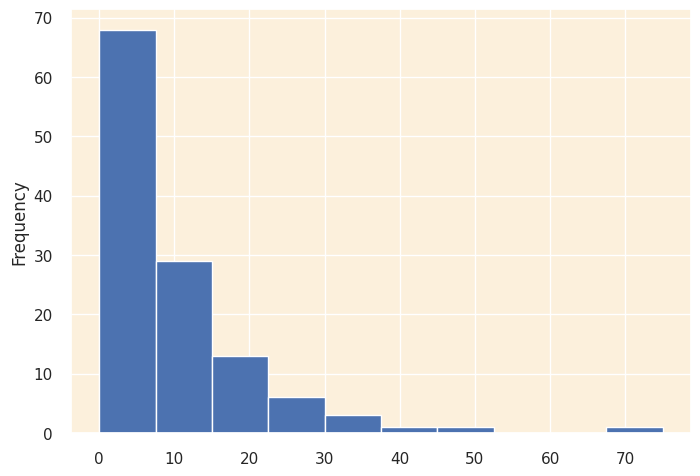

In [ ]:
((df_group.loc[1].diff().dropna()).apply(lambda x:x.days)).plot(kind="hist")
#plt.titlte("Diferencia entre dias")
plt.show()

Inference:

Si analizamos diferentes distribuciones de la diferencia de entre los dias que las diferentes fechas de compra podemos ver que la distribucion casi siempre estan segadas hacia la derecha lo que indica:

- Los clientes tienden hacer compras muy seguidas y no dejan pasar mucho tiempo hasta su siguente compra.
- Como la distribucion esta casi siempre sesgada una meejor representacion de los datos podria ser la mediana y no la media.
- La media para la siguiente distribucion es 9.6 y la mediana 7.0 y como podemos ver la mediana se ajusta mejor como valor representativo.

In [ ]:
((df_group.loc[1].diff().dropna()).apply(lambda x:x.days)).mean(),((df_group.loc[1].diff().dropna()).apply(lambda x:x.days)).median()

(np.float64(9.672131147540984), 7.0)

In [ ]:
data = []
for customerId in df["CustomerId"].unique():
  registry = {"CustomerId":customerId}
  registry["median"] = ((df_group.loc[customerId].diff().dropna()).apply(lambda x:x.days)).median()
  data.append(registry)
average_days_between_purchases = pd.DataFrame(data)
average_days_between_purchases.rename(columns={'median': 'Average_Days_Between_Purchases'}, inplace=True)
average_days_between_purchases

,CustomerId,Average_Days_Between_Purchases
0,803,7.0
1,105,7.0
2,57,9.0
3,905,7.0
4,976,6.0
...,...,...
658,1057,6.0
659,1058,8.0
660,1059,10.0
661,1061,0.0


In [ ]:
df.groupby("CustomerId")["InvoiceDay"].size()

,InvoiceDay
CustomerId,
1,406
2,361
3,437
4,316
5,384
...,...
1057,55
1058,50
1059,30


In [ ]:
df.columns

Index(['InvoiceLineId', 'InvoiceID', 'StockItemID', 'Description', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerId', 'Latitude', 'Longitude',
       'InvoiceDay', 'Total_Spend'],
      dtype='object')

#### Step 4.3.2 |  Dia Favorito de Compras

In [ ]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek

In [ ]:
df.columns

Index(['InvoiceLineId', 'InvoiceID', 'StockItemID', 'Description', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerId', 'Latitude', 'Longitude',
       'InvoiceDay', 'Total_Spend', 'Day_Of_Week'],
      dtype='object')

In [ ]:
# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerId', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day

,CustomerId,Day_Of_Week,Count
0,1,0,88
1,1,1,108
2,1,2,53
3,1,3,74
4,1,4,61
...,...,...,...
3962,1060,3,2
3963,1060,4,5
3964,1061,2,10
3965,1061,3,10


In [ ]:
favorite_shopping_day =  favorite_shopping_day.loc[favorite_shopping_day.groupby("CustomerId")["Count"].idxmax()][['CustomerId', 'Day_Of_Week']]
favorite_shopping_day

,CustomerId,Day_Of_Week
1,1,1
9,2,3
13,3,1
21,4,3
25,5,1
...,...,...
3946,1057,0
3952,1058,1
3956,1059,0
3963,1060,4


In [ ]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerId')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerId')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerId,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week
0,1,4,406,17327,305494.40,752.449261,189,7.0,1
1,2,17,361,14693,229142.90,634.744875,178,7.0,3
2,3,1,437,15874,307461.05,703.572197,191,7.0,1
3,4,33,316,13571,299127.85,946.607120,172,8.0,3
4,5,3,384,15480,257129.40,669.607813,178,8.0,1


## Step 4.4 | Geographic Features

Introduciremos una caracteristica geografica, que refleja la locacion geografica del cliente, entendiento la distribucion geografica del usuario es fundamental por varias razones:

- En nuestro base de datos en la tabla de Customer tenemos la ubicacion de cada cliente mediante su longitud y latitud en cual es muy buen indicardor para hacer segmentacion de clientes. sin embargo podrias usaar esta caracteristica dentro de "Content-Base Filtering" para tener un mejor analisis ya que estos datos viene a representar a la metadata del Cliente

-  La longitud y latitud se encuentran en grados y si usamos k-means no tendremos una buena representacion a menos que los puntos, sean muy cercano pero como podemos obeservar en grafico los puntos estan considerablemente lejason (se encuentran en otros paises). podrias usar DB-Scan  

In [ ]:
!pip install contextily


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 32.5 MB/s eta 0:00:00


In [ ]:
df.columns

Index(['InvoiceLineId', 'InvoiceID', 'StockItemID', 'Description', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerId', 'Latitude', 'Longitude',
       'InvoiceDay', 'Total_Spend', 'Day_Of_Week'],
      dtype='object')

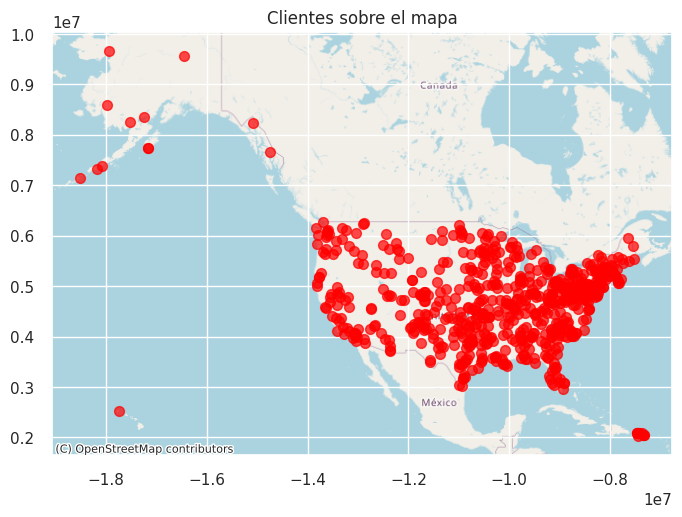

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Convert DataFrame to GeoDataFrame
# Add latitude and longitude back to customer_data for plotting
customer_data_geo = pd.merge(customer_data, df[['CustomerId', 'Latitude', 'Longitude']].drop_duplicates(), on='CustomerId')
gdf = gpd.GeoDataFrame(customer_data_geo, geometry=gpd.points_from_xy(customer_data_geo.Longitude, customer_data_geo.Latitude), crs="EPSG:4326")

# Reproyectar a Web Mercator (necesario para agregar tiles de mapas)
gdf = gdf.to_crs(epsg=3857)

ax = gdf.plot(figsize=(8,6), alpha=0.7, markersize=50, color="red")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # mapa de fondo
plt.title("Clientes sobre el mapa")
plt.show()

## Step 4.5 | Seasonality & Trends

En este paso entrare en la estacionalidad y la tendencia en los comportamientos de compra de los cliente, el cual ofrece "insights" para estrategias de marketing y enriquecer la satisfacion del cliente, aqui estan las caracteristicas que estamos buscando introducir.

- Promedio Mensualmenet Gastado : Esta en la cantidad promedio que gasta un cliente mensualmente. este nos ayuda como un indicador habito general de gasto de cada cliente, mayor promedio indica un cliente que gasta mas, potencialmente mostrando interés en productos mas costosos (premium), mientras que una media más baja podría indicar un cliente más consciente del presupuesto.

- Desviacion de lo gastado Mensualmente: Esta caracteristica indica la variabilidad de lo que gasta un cliente mensualemnte, un valor algo significa que lo que gasta el cliente fluctua significativamente de mes a mes, tal vez esto puede indicar compras largas esporadicas, por el contrario un valor mas pequeño es mas estable indicando que puede indicar un habito consistente de gasto. Entendiendo esta variabilidad nos puede ayudar, al crear promociones o descuentos personalizados durante los períodos en los que se espera que gasten más.

- Tendencia de Gasto: Esto refleja la tendencia de sobre lo que gasta un cliente sobre el tiempo, vamos a calcular la pendiente de la linea que se ajusta al los datos de sus gastos. una pendiente positiva indica un incremento en la tendencia y Posiblemente apunta a una creciente lealtad o satisfacción, por el contrario un la pendiente negativa indica un decreciente desinteres o satisfacion.destacando la necesidad de estrategias de reactivación, un valore cercano a cero puede indicar habitos de gasto estables. reconociendo estas tendecias, reconocer estas tendencias puede ayudar a desarrollar estrategias para mantener o modificar los patrones de gasto de los clientes, mejorando así la eficacia de las campañas de marketing.

Incorporando estos insights puede ayudarnos a la segmentacion de nuestros cleintes, puede ayudarnos a crearmos mejores grupos en nuestro algoritmos de clustering.

### Step 4.5.1 | Promedio Mensualmenet Gastado

In [ ]:
df.columns

Index(['InvoiceLineId', 'InvoiceID', 'StockItemID', 'Description', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerId', 'Latitude', 'Longitude',
       'InvoiceDay', 'Total_Spend', 'Day_Of_Week'],
      dtype='object')

In [ ]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

In [ ]:
monthly_spending = df.groupby(["CustomerId","Year","Month"])["Total_Spend"].sum().reset_index()
monthly_spending.head(10)

,CustomerId,Year,Month,Total_Spend
0,1,2013,3,10338.75
1,1,2013,4,16747.95
2,1,2013,5,1332.00
3,1,2013,6,12210.50
4,1,2013,7,6092.80
5,1,2013,8,2642.60
6,1,2013,9,10916.00
7,1,2013,10,6848.20
8,1,2013,11,2320.00
9,1,2013,12,7024.00


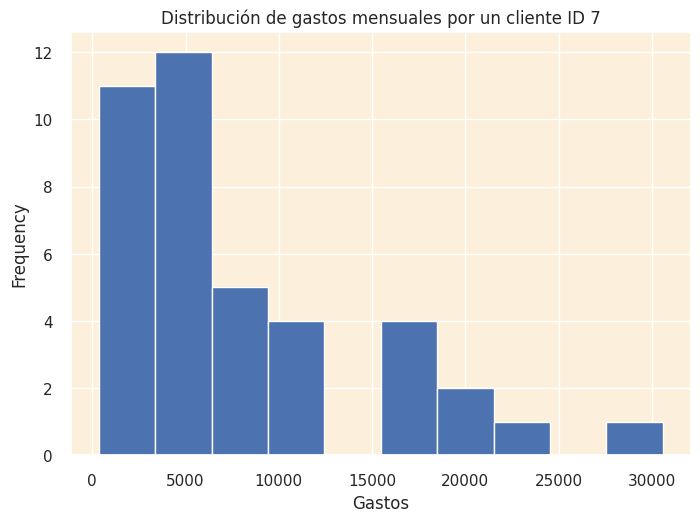

In [ ]:
# Mejor represenatcion de gastos por clientes,
fig,ax = plt.subplots(1,1)
spending_monthtly_customer = (monthly_spending[monthly_spending["CustomerId"] == 7]["Total_Spend"])
spending_monthtly_customer.plot(kind="hist",ax=ax)
ax.set_title("Distribución de gastos mensuales por un cliente ID 7")
ax.set_xlabel("Gastos")
plt.show()

In [ ]:
spending_monthtly_customer.mean(),spending_monthtly_customer.median()

(np.float64(8135.39375), 5284.325)

Inference:
- Analizando diferentes distribuciones de gastos mensuales por cliente, podemos ver que la distribucion es casi siempre en su mayoria de casos sesgada con outliers, represetar los datos solo con la media quizas no sea la mejor representacion, usando la mediana seria una manera mas adecuada.
- Un ejemplo claro es un customer con ID 7 el cual los gastos mensuales que ha hecho en todo esta tiempo esta representado con una media de 8135.3 y una mediana 5284.3 y mirando el grafico podemos ver que la mediana es la que mejore se ajusta al grafico.
- Si usamos la mediana debemos usar el rango intercuartil, para medir la dispercion de nuestros datos.

In [ ]:
def iqr(x):
    return np.percentile(x, 75) - np.percentile(x, 25)

In [ ]:
# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby("CustomerId")["Total_Spend"].agg(['median', iqr]).reset_index()
seasonal_buying_patterns.rename(columns={'median': 'Monthly_Spending_median', 'iqr': 'Monthly_Spending_td'}, inplace=True)
seasonal_buying_patterns

,CustomerId,Monthly_Spending_median,Monthly_Spending_td
0,1,6470.500,7701.5500
1,2,5657.800,4076.7000
2,3,6041.200,8662.0125
3,4,5664.600,7861.6000
4,5,5388.975,6150.7125
...,...,...,...
658,1057,7588.200,7754.6000
659,1058,13126.500,5749.2000
660,1059,3818.800,1740.6500
661,1060,7240.200,0.0000


In [ ]:
# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_td'].fillna(0, inplace=True)
seasonal_buying_patterns

,CustomerId,Monthly_Spending_median,Monthly_Spending_td
0,1,6470.500,7701.5500
1,2,5657.800,4076.7000
2,3,6041.200,8662.0125
3,4,5664.600,7861.6000
4,5,5388.975,6150.7125
...,...,...,...
658,1057,7588.200,7754.6000
659,1058,13126.500,5749.2000
660,1059,3818.800,1740.6500
661,1060,7240.200,0.0000


In [ ]:
# Calculate Trends in Spending
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

In [ ]:
# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby("CustomerId")["Total_Spend"].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)
spending_trends

,CustomerId,Spending_Trend
0,1,-8.472054
1,2,67.049615
2,3,-57.311177
3,4,105.881373
4,5,39.554400
...,...,...
658,1057,-257.775000
659,1058,4702.640000
660,1059,432.400000
661,1060,0.000000


In [ ]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerId')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerId')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerId,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_median,Monthly_Spending_td,Spending_Trend
0,1,4,406,17327,305494.40,752.449261,189,7.0,1,6470.500,7701.5500,-8.472054
1,2,17,361,14693,229142.90,634.744875,178,7.0,3,5657.800,4076.7000,67.049615
2,3,1,437,15874,307461.05,703.572197,191,7.0,1,6041.200,8662.0125,-57.311177
3,4,33,316,13571,299127.85,946.607120,172,8.0,3,5664.600,7861.6000,105.881373
4,5,3,384,15480,257129.40,669.607813,178,8.0,1,5388.975,6150.7125,39.554400


Hemos creado un dataset que se centrar en mis customers, usando una gran variedad de nuevas caracteristicas. que nos da un entendimiento muy amplio de los patrones de comprar y sus preferencias

In [ ]:
# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [ ]:
customer_data.head(10)

,CustomerId,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_median,Monthly_Spending_td,Spending_Trend
0,1,4,406,17327,305494.4,752.449261,189,7.0,1,6470.5,7701.55,-8.472054
1,2,17,361,14693,229142.9,634.744875,178,7.0,3,5657.8,4076.7,67.049615
2,3,1,437,15874,307461.05,703.572197,191,7.0,1,6041.2,8662.0125,-57.311177
3,4,33,316,13571,299127.85,946.60712,172,8.0,3,5664.6,7861.6,105.881373
4,5,3,384,15480,257129.4,669.607813,178,8.0,1,5388.975,6150.7125,39.5544
5,6,0,363,14266,256737.6,707.266116,181,9.0,2,4298.0,4796.225,-128.058583
6,7,4,412,14821,325415.75,789.844053,184,6.0,2,5284.325,8608.7,-55.171037
7,8,11,315,13731,230582.2,732.006984,180,6.0,1,5983.6,6627.0,-8.308701
8,9,7,346,14371,283113.75,818.247832,174,7.0,3,6793.8,7416.6,56.183239
9,10,7,385,14561,317126.45,823.705065,179,7.0,3,4521.75,8042.3,172.674461


In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerId                      663 non-null    Int64  
 1   Days_Since_Last_Purchase        663 non-null    Int64  
 2   Total_Transactions              663 non-null    Int64  
 3   Total_Products_Purchased        663 non-null    Int64  
 4   Total_Spend                     663 non-null    Float64
 5   Average_Transaction_Value       663 non-null    Float64
 6   Unique_Products_Purchased       663 non-null    Int64  
 7   Average_Days_Between_Purchases  663 non-null    Float64
 8   Day_Of_Week                     663 non-null    Int32  
 9   Monthly_Spending_median         663 non-null    Float64
 10  Monthly_Spending_td             663 non-null    Float64
 11  Spending_Trend                  663 non-null    Float64
dtypes: Float64(6), Int32(1), Int64(5)
me

vamos hacer un overview de la descripcion de las nueva columnas que hemos creado.

| Variable                       | Description                                                                                                                                 |
|--------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| CustomerID                     | Identificador unico del Customer|
| Days_Since_Last_Purchase       | El número de días que han pasado desde la última compra del cliente.                                                                    |
| Total_Transactions             | El número total de transacciones realizadas por el cliente..                                                                                     |
| Total_Products_Purchased       | La cantidad total de productos comprados por el cliente en todas las transacciones.                                                           |
| Total_Spend                    | La cantidad total de dinero que el cliente ha gastado en todas las transacciones.                                                                   |
| Average_Transaction_Value      | El valor promedio de las transacciones del cliente, calculado como el gasto total dividido por el número de transacciones.                          |
| Unique_Products_Purchased      | La cantidad de productos diferentes que el cliente ha comprado..                                                                                |
| Average_Days_Between_Purchases | El número promedio de días entre compras consecutivas realizadas por el cliente.                                                              |
| Day_Of_Week                    | El día de la semana en que el cliente prefiere comprar, representado numéricamente (0 para lunes, 6 para domingo).                                |
| Monthly_Spending_Mean          | El gasto mensual promedio (mediana) del cliente.                                                                                              |
| Monthly_Spending_Std           | La desviación (Rango Intercuartil) del gasto mensual del cliente, que indica la variabilidad en su patrón de gasto.                           |
| Spending_Trend                 | Representación numérica de la tendencia del gasto del cliente a lo largo del tiempo. Un valor positivo indica una tendencia al alza, un valor negativo, una tendencia a la baja y un valor cercano a cero, una tendencia estable. |

Ahora que nuestro dataset está listo, podemos avanzar a los siguientes pasos del proyecto. Esto incluye analizar nuestros datos con mayor detenimiento para identificar patrones o tendencias, asegurarnos de que estén en óptimas condiciones mediante la detección y gestión de valores atípicos, y prepararlos para el proceso de agrupamiento. Todos estos pasos nos ayudarán a sentar una base sólida para crear nuestros segmentos de clientes y, en última instancia, un sistema de recomendaciones personalizado.

# Step 5 | Outlier Detection and Treatment

- Voy a indentidicar y manejar outliers dentro de mi dataset, Los outliers son puntos que son signficativamente distintos de la mayoria de otros puntos, Estos puntos pueden distorcionar nuestros resultados de nuesro analisis especialmente porque K-means clustering, Donde pueden significativamente influir en la posicion del cluster del centroide, por lo que es necesario identificar y tratar estoy outliers apropiadamente para lograr resultados de agrupamiento más precisos y significativos.

- Debido a que nuestro dataset es multi-dimensional seria pruedente usar un algoritmo que puede detectar outlieres en un espacio multidimensional, en este caso vamos a usar "Isolation Forest" para esta tarea. esta algoritmos bien para datos multi-dimensioanles y es computacionalmente efficiente, Aísla las observaciones seleccionando aleatoriamente una característica y luego seleccionando aleatoriamente un valor dividido entre los valores máximo y mínimo de la característica seleccionada.

In [ ]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination="auto", random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerId,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_median,Monthly_Spending_td,Spending_Trend,Outlier_Scores,Is_Outlier
0,1,4,406,17327,305494.4,752.449261,189,7.0,1,6470.5,7701.55,-8.472054,1,0
1,2,17,361,14693,229142.9,634.744875,178,7.0,3,5657.8,4076.7,67.049615,1,0
2,3,1,437,15874,307461.05,703.572197,191,7.0,1,6041.2,8662.0125,-57.311177,1,0
3,4,33,316,13571,299127.85,946.60712,172,8.0,3,5664.6,7861.6,105.881373,1,0
4,5,3,384,15480,257129.4,669.607813,178,8.0,1,5388.975,6150.7125,39.5544,1,0


- Despues de aplicar el algoritmo "Isolation Forest" hemos identificado los outliers y marcados en una nueva columna nombrada " Is_Outlier", También hemos calculado las puntuaciones de valores atípicos que representan la puntuación de anomalía de cada registro.

Ahora visualicemos la distribución de estas puntuaciones y el número de valores atípicos y valores normales detectados por el modelo:

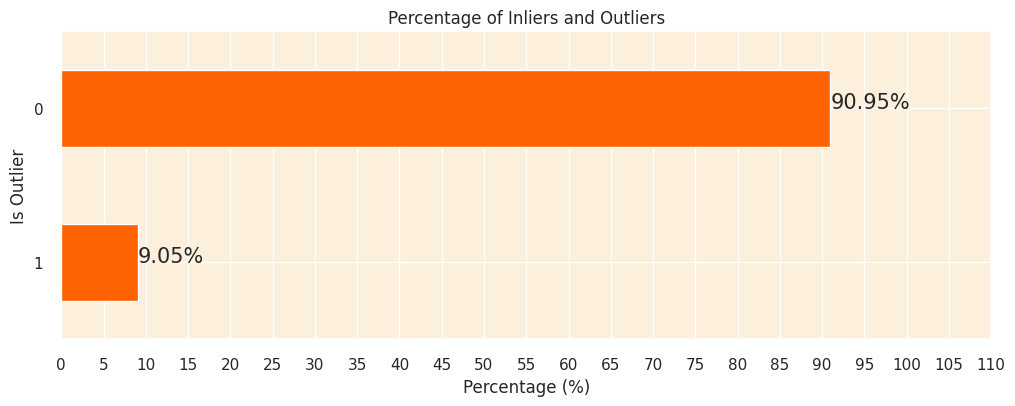

In [ ]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

Inferencia:

Del gráfico, observamos que aproximadamente el 7.99 % de los clientes se han identificado como outliers en nuestro conjunto de datos. Este porcentaje parece razonable, ni demasiado alto como para perder una cantidad significativa de datos ni demasiado bajo como para retener puntos de datos potencialmente ruidosos. Esto sugiere que nuestro algoritmo de bosque de aislamiento ha funcionado bien al identificar un porcentaje moderado de valores atípicos, lo cual será crucial para refinar nuestra segmentación de clientes.

Estrategia :

Considerando que vamos a segmentar clientes usando clustering, es importante que manejemos outliers y preveer de que estos nos afecten a los outliers,removeremos los outlieres de el dataset para poder usar un algoritmo de clustering.


In [ ]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

Hemos removido los outliers de nuestro dataset parar un analisis mas profundo, ahora tenemos un dataset limpio sin outlieres, sigamos con los siguientes pasos para el proyecto de segmentacion de clientes,

In [ ]:
customer_data_cleaned.shape,outliers_data.shape

((603, 12), (60, 14))

# Step 6 | Correlation Analysis

Antes de proceder a la agrupación en clústeres con KMeans, es fundamental comprobar la correlación entre las características de nuestro conjunto de datos. La presencia de multicolinealidad, donde las características están altamente correlacionadas, puede afectar potencialmente el proceso de agrupación en clústeres al impedir que el modelo aprenda los patrones subyacentes reales en los datos, ya que las características no proporcionan información única. Esto podría generar agrupaciones poco separadas y significativas.


Si identificamos multicolinealidad, podemos utilizar técnicas de reducción de dimensionalidad como el PCA. Estas técnicas ayudan a neutralizar el efecto de la multicolinealidad transformando las características correlacionadas en un nuevo conjunto de variables no correlacionadas, preservando la mayor parte de la varianza de los datos originales. Este paso no solo mejora la calidad de las agrupaciones formadas, sino que también aumenta la eficiencia computacional del proceso de agrupación en clústeres.

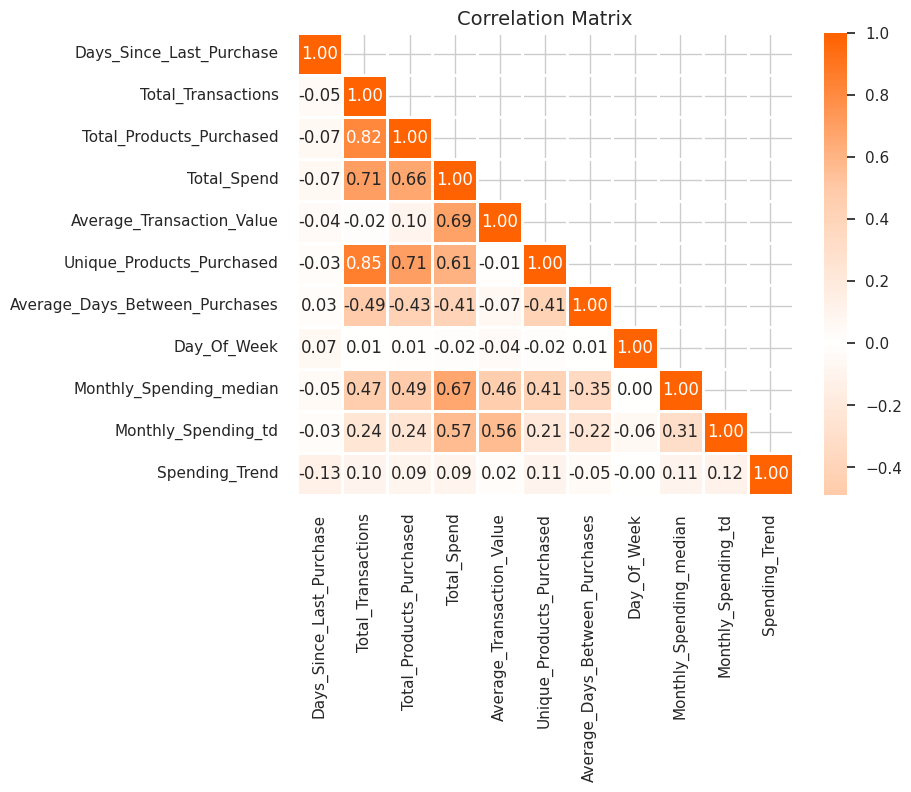

In [ ]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerId']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Inferencia:

Al observar el "Heat Map", podemos ver que hay algunos pares de variables con altas correlaciones, por ejemplo:

- Total_product_purchased y Total_transactions
- Total_spend y Total_transactions
- Unique_products_purchased y Total_transactions
- Total_spend y Total_products_purchased
- Unique_products_purchased y Total_products_purchased
- Average_Transaction_value y Total_spend
- Montly_spending_median y Total_spend

Estas altas correlaciones indican que estas variables se mueven estrechamente entre sí, lo que implica un grado de multicolinealidad.

Antes de continuar con los siguientes pasos, considerando el impacto de la multicolinealidad en el algoritmo de KMeans, podría ser beneficioso tratar esta multicolinealidad mediante técnicas de reducción de dimensionalidad como el PCA para crear un conjunto de variables no correlacionadas. Esto ayudará a lograr agrupaciones más estables durante el proceso de agrupación de KMeans.

# Step 7 | Feature Scaling

Antes de continuar con la agrupación y la reducción de dimensionalidad, es fundamental escalar nuestras variables. Este paso es crucial, especialmente en el contexto de algoritmos basados en la distancia como K-means y métodos de reducción de dimensionalidad como el PCA, Algunas razones serian:

- Para k-Means Clustering y PCA que descansan fuertemente en el concepto de distancia, para poder formar cluster o grupos, cuando las variables o caracteristiacs no tiene la misma escala, las variables con valores mas largos, tiene mas influencia en la salida de los clusters esto pued conllevar a grupos mas formados.

- Para el análisis de componentes principales (PCA): El PCA busca encontrar las direcciones donde los datos presentan mayor variación. Cuando las características no se escalan, las que presentan valores mayores podrían predominar sobre estos componentes, sin reflejar con precisión los patrones subyacentes en los datos.

Metodología:

Por lo tanto, para asegurar una influencia equilibrada en el modelo y revelar los verdaderos patrones en los datos, estandarizaré nuestros datos, es decir, transformaré las características para que tengan una media de 0 y una desviación estándar de 1. Sin embargo, no todas las características requieren escalamiento. A continuación, se presentan las excepciones y las razones por las que se excluyen, algo tambien a tener en cuenta es que no existe solo una forma de escalar nuestros datos, otra forma que podria ser adecuada seria con RobustScaler qué hace : Usa la mediana y el IQR (rango intercuartílico) en vez de la media y desviación estándar.

- CustomerID: Esta variable es solo un identificador para los clientes y no contiene ninguna información significativa para la agrupación.
- Day_of_week : Esta variable representa el día de la semana en que el cliente realizó transacciones con mayor frecuencia. Al ser una variable que categórica representada por números enteros (del 1 al 7), no sería necesario escalarla. Procederé a escalar las demás características del conjunto de datos para prepararlo para el análisis de componentes principales (PCA) y la agrupación en clústeres de K-medias, Para dia de la semana hay que agregar una observacion importante ya que este no refleja correctamente los valores por ejemplo si hablamos de que el lunes y el domingo como valores de 1 y 7 estos pueden interpretarse que estan lejos pero la verdad es que estoy valores son cercanos, podrias considerar transformar estos valores ciclicamente.Podemos usar CyclicalFeatures Ese transformador permite convertir variables numéricas que representan fenómenos con naturaleza cíclica en dos nuevas variables mediante funciones seno y coseno

In [ ]:
customer_data_cleaned["Day_Of_Week"].max(),customer_data_cleaned["Day_Of_Week"].min()

(np.int32(4), np.int32(0))

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerId', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerId,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_median,Monthly_Spending_td,Spending_Trend
0,1,-0.602249,1.365541,1.876315,0.999565,-0.000055,1.383031,-0.459216,1,0.888020,0.535855,-0.286046
1,2,0.755930,0.117513,0.399355,-1.058063,-1.585694,0.136104,-0.459216,3,0.061930,-1.852436,0.585229
2,3,-0.915675,2.225294,1.061576,1.052565,-0.658495,1.609745,-0.459216,1,0.451647,1.168671,-0.849490
3,4,2.427536,-1.130516,-0.229783,0.827990,2.615518,-0.544039,0.514096,3,0.068842,0.641306,1.033221
4,5,-0.706725,0.755394,0.840649,-0.303843,-1.116042,0.136104,0.514096,1,-0.211325,-0.485940,0.268023


# Step 8 | Dimensionality Reduction

Por qué necesitamos la reducción de la dimensionalidad ?

- Multicolinealidad detectada: En los pasos anteriores, identificamos que nuestro conjunto de datos contiene características multicolineales. La reducción de la dimensionalidad puede ayudarnos a eliminar la información redundante y a aliviar el problema de la multicolinealidad.

- Mejor agrupación con K-means: Dado que K-means es un algoritmo basado en la distancia, tener un gran número de características a veces puede diluir los patrones mas significativos en los datos. Al reducir la dimensionalidad, podemos ayudar a K-means a encontrar grupos (clusters) más compactos y bien separados.

- Reducción del ruido: Al centrarnos solo en las características más importantes, podemos eliminar potencialmente el ruido en los datos, lo que lleva a clústeres más precisos y estables.

- Visualización mejorada: En el contexto de la segmentación de clientes, ser capaz de visualizar los grupos de clientes en dos o tres dimensiones puede proporcionar información intuitiva. Las técnicas de reducción de la dimensionalidad pueden facilitar esto al reducir los datos a unos pocos componentes principales que se pueden graficar fácilmente.

- Eficiencia computacional mejorada: Reducir el número de características puede acelerar el tiempo de cálculo durante el proceso de modelado, haciendo que nuestro algoritmo de agrupación sea más eficiente.

Procedamos a seleccionar un método de reducción de la dimensionalidad apropiado para nuestros datos.

¿Qué método de reducción de la dimensionalidad?

En este paso, estamos considerando la aplicación de técnicas de reducción de la dimensionalidad para simplificar nuestros datos mientras se conserva la información esencial. Entre varios métodos como KernelPCA, ICA, ISOMAP, TSNE y UMAP, estoy comenzando con PCA (Análisis de Componentes Principales). Aquí está el porqué:

PCA es un excelente punto de partida porque funciona bien capturando relaciones lineales en los datos, lo cual es particularmente relevante dada la multicolinealidad que identificamos en nuestro conjunto de datos. Nos permite reducir el número de características en nuestro conjunto de datos al mismo tiempo que retiene una cantidad significativa de la información, lo que hace que nuestro análisis de agrupación sea potencialmente más preciso e interpretable. Además, es computacionalmente eficiente, lo que significa que no aumentará significativamente el tiempo de procesamiento.

Sin embargo, es esencial tener en cuenta que tenemos opciones a considerar. Después de aplicar PCA, si encontramos que los primeros componentes no capturan una cantidad significativa de la varianza, lo que indica una pérdida de información vital, podríamos considerar explorar otros métodos no lineales. Estos métodos pueden proporcionar un enfoque más matizado para la reducción de la dimensionalidad, capturando patrones complejos que PCA podría pasar por alto, aunque a costa de un mayor tiempo de cálculo y complejidad.

Metodología

Aplicaremos PCA a todos los componentes disponibles y trazaré la varianza acumulada explicada por ellos. Este proceso me permitirá visualizar cuánta varianza puede explicar cada componente principal adicional, ayudándome así a determinar el número óptimo de componentes a retener para el análisis.

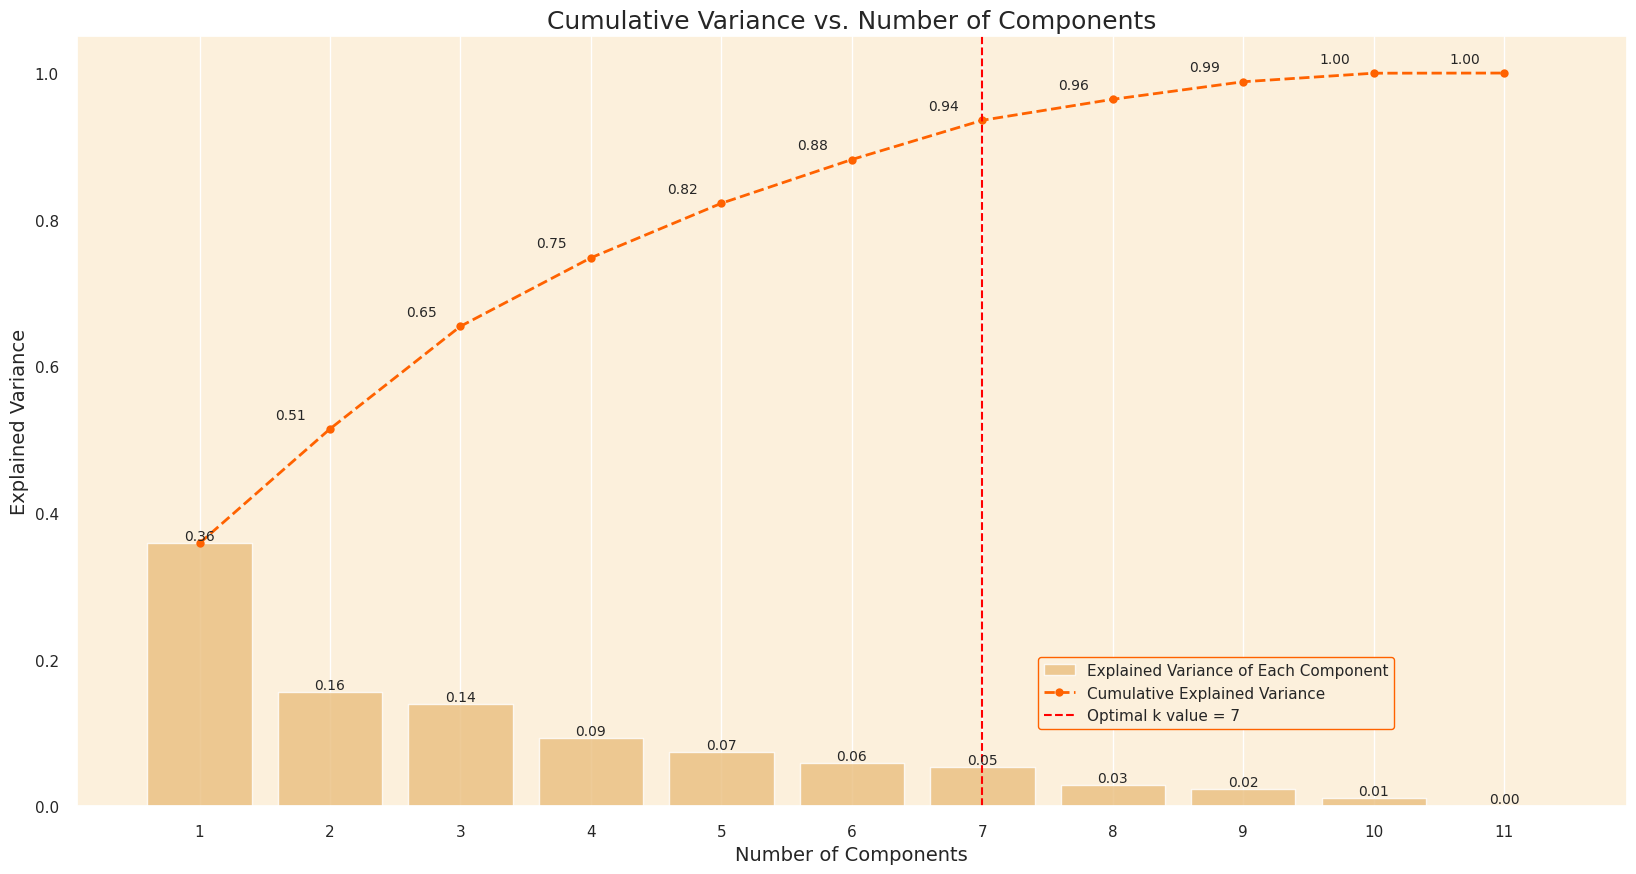

In [ ]:
# Setting CustomerID as the index column

# Importante añadir dentro del despliegue
customer_data_scaled.set_index('CustomerId', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 7

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

El componente 1 explica ~36% de la varianza.

- Con 3 componentes ya capturamos el ~65%.
- Con 5 componentes alcanzamos el ~82%.
- Con 7 componentes llegamos al ~94%.

A partir del septimo componente, el aumento es mínimo ente el 9 al 100 porciento, esto se conoce como el punto de codo (elbow), después del 7, la ganancia de agregar más componentes es muy baja, entonces tener 7 componentes es una elección razonable y balanceada reducimos, de 11 a 7 dimensiones, conservando el 94% de la variabilidad.

Si buscaramos más compresión (menos dimensiones), podríamos quedarnos con 5 o 6 dimesiones que representan el 82 y 88 porciento de la variabilidad, pero perderiamos algo de información.

In [ ]:
# Creating a PCA object with 6 components
pca = PCA(n_components=7)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [ ]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
CustomerId,,,,,,,
1,2.893941,-0.378155,-1.122531,-0.051721,-0.632581,0.494532,-0.209565
2,-0.876086,2.131618,-1.529839,0.070736,0.754084,-0.233934,1.129378
3,2.878917,-0.269560,-1.492821,-0.208074,-1.058742,0.316643,-1.188297
4,0.140125,-0.047693,3.173640,-0.965622,2.231369,0.417703,0.341890
5,0.058531,-0.174206,-1.714919,0.678802,-0.255782,0.696768,-0.161196


Ahora, extraigamos los coeficientes correspondientes a cada componente principal para comprender mejor la transformación realizada por PCA:

In [ ]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #750000' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Days_Since_Last_Purchase,-0.043794,0.098400,0.036662,-0.699251,0.698701,0.038016,0.075182
Total_Transactions,0.415580,0.159911,-0.290868,-0.025653,-0.000653,0.131310,-0.126401
Total_Products_Purchased,0.399926,0.126950,-0.209453,-0.015232,-0.046680,0.192088,-0.047730
Total_Spend,0.446535,-0.083127,0.204041,-0.050660,-0.046488,0.140277,-0.003880
Average_Transaction_Value,0.207681,-0.282773,0.589309,-0.050546,-0.063218,0.067243,0.113905
Unique_Products_Purchased,0.383205,0.140022,-0.300852,-0.029549,0.034711,0.198322,-0.169995
Average_Days_Between_Purchases,-0.283233,-0.071679,0.141257,0.066299,0.021417,0.919961,-0.117885
Day_Of_Week,-0.019228,0.886931,0.446361,0.087564,-0.054278,-0.017087,-0.048071
Monthly_Spending_median,0.350218,-0.045738,0.168485,-0.012401,-0.037673,0.066768,0.696273
Monthly_Spending_td,0.258047,-0.218934,0.378381,0.000023,0.130290,-0.172120,-0.650610


# Step 9 | K-Means Clustering

K-Means:

K-Means es un algoritmo de aprendizaje automático no supervisado que agrupa los datos en un número específico de grupos (K) minimizando la suma de los cuadrados dentro del clúster (WCSS), también conocida como inercia. El algoritmo asigna de forma iterativa cada punto de datos al centroide más cercano y luego actualiza los centroides calculando la media de todos los puntos asignados. El proceso se repite hasta que se alcanza la convergencia o un criterio de parada.

Inconvenientes de K-Means
- La inercia está influenciada por el número de dimensiones: El valor de la inercia tiende a aumentar en espacios de alta dimensionalidad debido a la maldición de la dimensionalidad, lo que puede distorsionar las distancias euclidianas entre los puntos de datos.

  - Solución: Realizar una reducción de la dimensionalidad, como PCA, antes de aplicar K-means para mitigar este problema y acelerar los cálculos.

- Dependencia de la colocación inicial del centroide: El algoritmo de K-means podría encontrar un mínimo local en lugar de un mínimo global, dependiendo de dónde se coloquen los centroides inicialmente.

  -Solución: Para aumentar la probabilidad de encontrar el mínimo global, podemos emplear el método de inicialización k-means++.

- Requiere especificar el número de clústeres: K-means requiere especificar el número de clústeres (K) de antemano, lo que puede no conocerse con anticipación.

  - Solución: Utilizar métodos como el método del codo y el análisis de la silueta para estimar el número óptimo de clústeres.

- Sensibilidad a clústeres de tamaño desigual o dispersos: K-means puede tener dificultades con clústeres de diferentes tamaños o densidades.

  - Solución: Aumentar el número de inicializaciones aleatorias (n_init) o considerar el uso de algoritmos que manejan mejor los clústeres de tamaño desigual, como GMM o DBSCAN.

- Asume clústeres convexos e isotrópicos: K-means asume que los clústeres son esféricos y tienen varianzas similares, lo que no siempre es el caso. Puede tener dificultades con clústeres alargados o de forma irregular.

  - Solución: Considerar el uso de algoritmos de agrupación que no hagan estas suposiciones, como DBSCAN o el Modelo de Mezcla Gaussiana (GMM).

Tomando en cuenta las consideraciones mencionadas, apliquemos inicialmente PCA al conjunto de datos. Para el algoritmo de K-Means, establecerremos el parámetro init en k-means++ y n_init en 10. Para determinar el número óptimo de clústeres (agrupamientos), empleaaremos el método del codo y el análisis de la silueta. Además, podría ser beneficioso explorar el uso de algoritmos de agrupación alternativos, como GMM y DBSCAN, en futuros análisis para mejorar  los resultados de la agrupacion.

## Step 9.1 | Determining the Optimal Number of Clusters

Para determinar el número óptimo de clústeres (k) para segmentar clientes, exploraremos dos métodos conocidos:

- Método del Codo
- Método de la Silueta

### Step 9.1.1 | Elbow Method

El Método del Codo es una técnica utilizada para determinar el número óptimo de clústeres (k) en un conjunto de datos. La idea es simple: ejecutar el algoritmo K-means para diferentes valores de k y, en cada caso, calcular la inercia (también conocida como WCSS o la suma de los cuadrados de las distancias dentro del clúster).

La inercia mide cuán compactos son los clústeres; un valor más bajo indica clústeres más densos y mejor formados. A medida que aumenta el valor de k, la inercia siempre disminuirá, ya que cada punto estará más cerca de su centroide. El gráfico de la inercia versus el número de clústeres (k) generalmente tendrá una forma de brazo doblado . El punto donde el brazo se dobla bruscamente (el "codo") es el valor de k que buscamos, porque a partir de ese punto, agregar más clústeres no reduce significativamente la inercia, lo que sugiere que se está obteniendo un rendimiento decreciente.

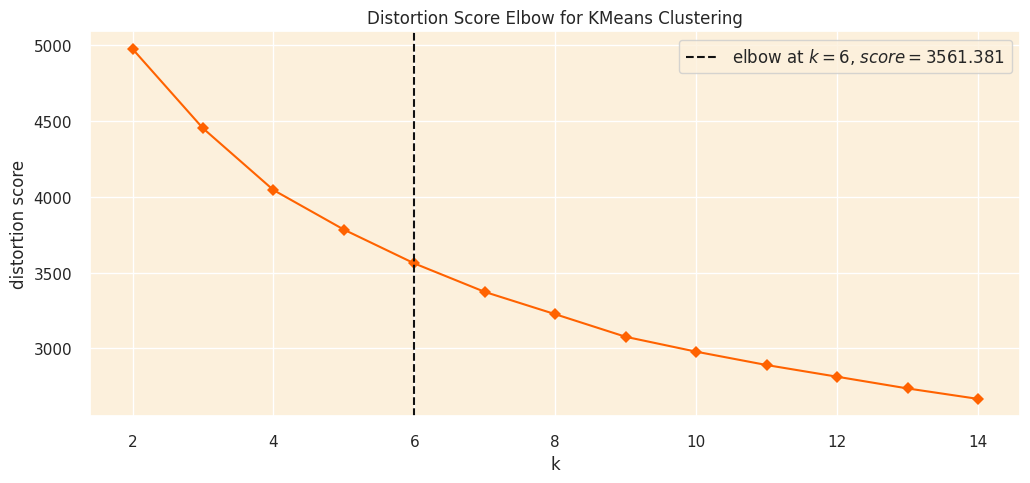

In [ ]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

El Método del Codo sugiere que el número óptimo de clústeres (k) para el algoritmo K-Means es 6.

Sin embargo, debido a que el "codo" no es muy pronunciado en el gráfico, el valor óptimo de k podría estar en un rango de 4 a 8. Para confirmar el mejor valor, se recomienda usar el análisis de la silueta y, lo que es igualmente importante, incorporar el conocimiento del negocio para asegurarse de que el número de clústeres sea práctico y útil para los objetivos de la segmentación.

### Step 9.1.2 | Silhouette Method

El Método de la Silueta es una técnica para encontrar el número óptimo de clústeres (k) al evaluar qué tan bien formados y separados están los clústeres. Calcula un coeficiente de silueta para cada punto de datos, el cual mide cuán similar es un punto a su propio clúster en comparación con otros clústeres. El coeficiente de silueta es un valor entre -1 y 1. Un valor alto y positivo indica que el punto está bien agrupado, mientras que un valor bajo o negativo sugiere que el punto está mal asignado o se encuentra entre clústeres.

- El puntaje de la silueta es el promedio de los coeficientes de silueta para todos los puntos de datos, dando una medida general de la calidad de la agrupación. Un puntaje más alto indica una mejor configuración de clústeres.

- Ventajas del Método de la Silueta sobre el Método del Codo
Evaluación Integral: El Método de la Silueta considera tanto la cohesión dentro de un clúster como la separación de otros clústeres. Por el contrario, el Método del Codo solo evalúa la cohesión (inercia). Esto hace que el análisis de la silueta sea una medida más completa de la calidad de la agrupación.

- Menos Subjetivo: El Método de la Silueta produce un puntaje directo y cuantificable, lo que facilita la comparación de diferentes valores de k. El Método del Codo, por su parte, se basa en la interpretación subjetiva de un "codo", el cual puede no ser claro en todos los conjuntos de datos.

- Detección de Anormalidades: El Método de la Silueta también permite visualizar la calidad de cada clúster individualmente, lo que ayuda a identificar clústeres que contienen puntos que no encajan bien.

Metodología

En el siguiente análisis:

- Inicialmente, elegiré un rango de 2 a 7 para el número de clústeres (k), basándome en el método del codo de la sección anterior.

- A continuación, graficaré los puntajes de la silueta para cada valor de k para determinar el que tenga el puntaje más alto.

- Posteriormente, para afinar la selección del k más apropiado, generaré gráficos de silueta que muestren visualmente los coeficientes de silueta para cada punto de datos dentro de varios clústeres.

La biblioteca YellowBrick se utilizará una vez más para crear estos gráficos y facilitar un análisis comparativo.

In [ ]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

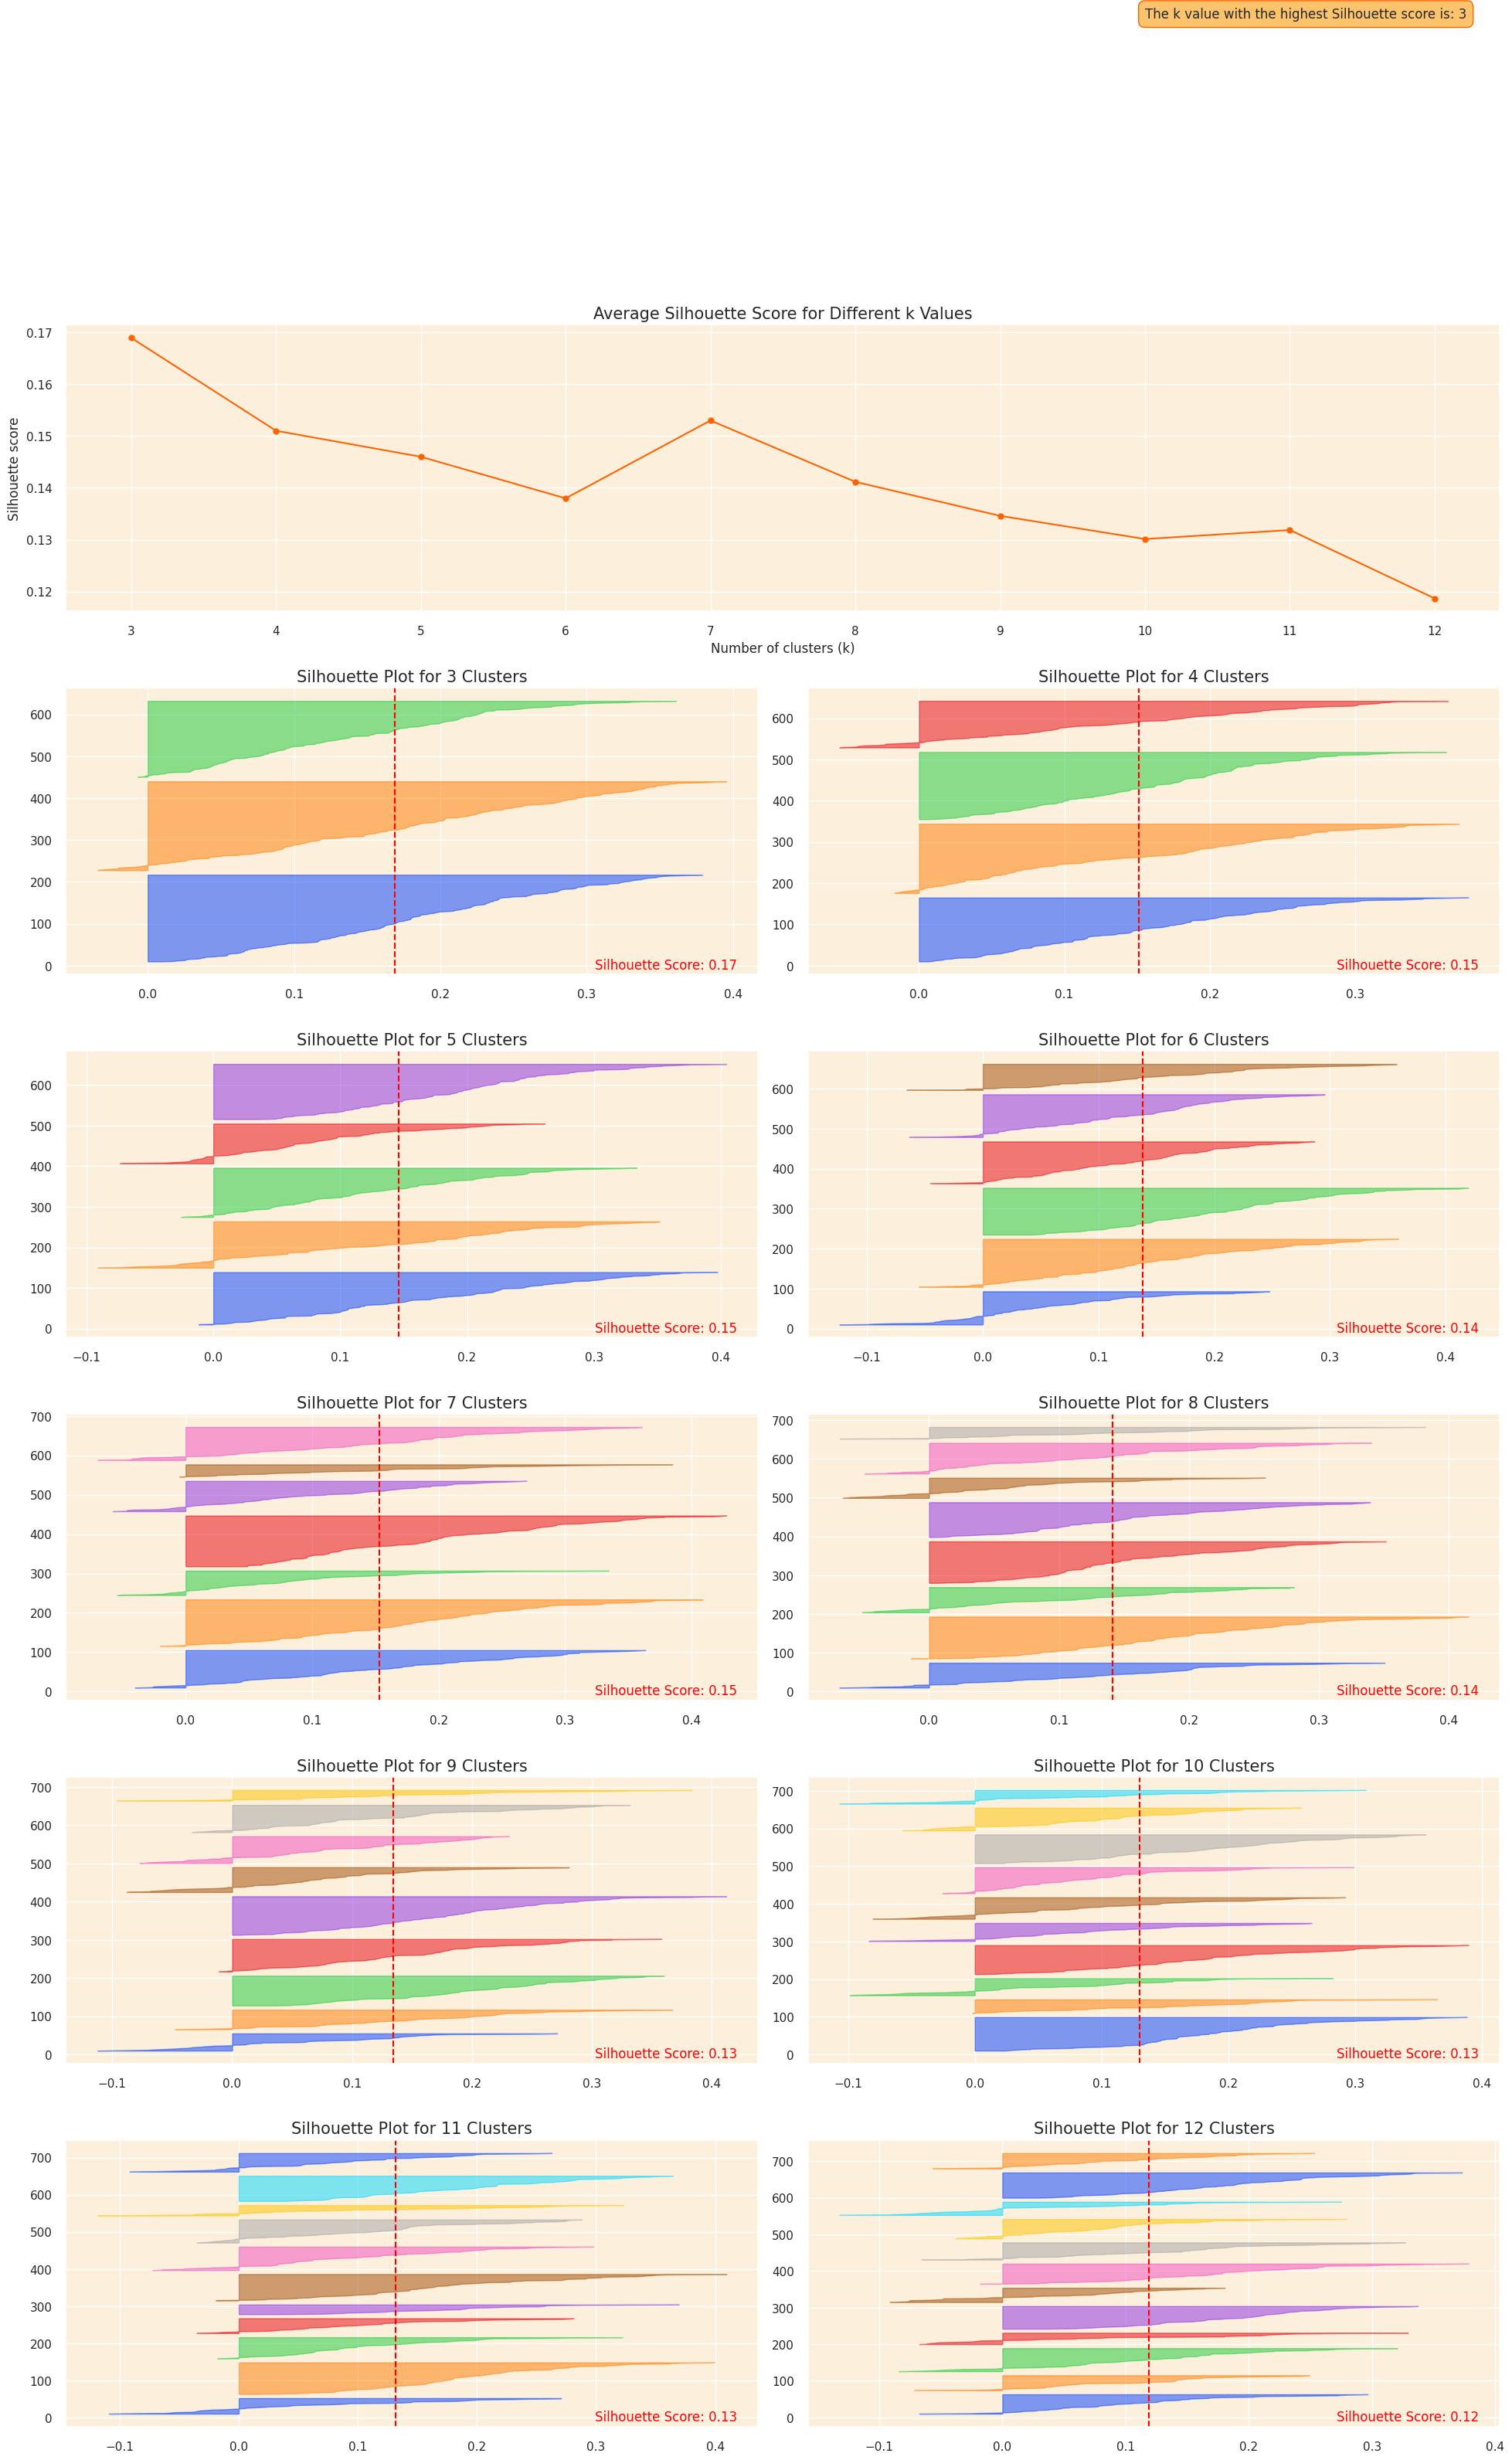

In [ ]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

Analizando el Método de la Silueta

Basándonos en el gráfico de puntaje de silueta promedio, el número óptimo de clústeres (k) es 3, ya que este valor tiene el puntaje más alto (aproximadamente 0.17).

Al analizar los gráficos de silueta individuales para cada valor de k, los de 3, 5 y 6 clústeres parecen ser los más prometedores. Los clústeres en estos gráficos son relativamente uniformes en tamaño y no hay coeficientes negativos, lo que indica que todos los puntos de datos están bien agrupados.

Aunque el gráfico sugiere que k=3 tiene el mejor puntaje de silueta, el puntaje promedio para todos los valores de k es bastante bajo. Esto podría ser un indicio de que los datos no tienen clústeres bien definidos o que el algoritmo K-Means no es el más adecuado para este conjunto de datos.

Analizando k=3 Clusters

- Puntaje de Silueta: El valor de 0.17 es el puntaje de silueta promedio para los tres clústeres, este valor es una medida general de cuán bien están separados los clústeres. Un puntaje cercano a 1 indica que los clústeres están bien definidos y separados, mientras que un valor cercano a 0 o negativo sugiere que los clústeres se superponen o están mal definidos. Un valor de 0.17 es bastante bajo, lo que indica que, si bien los 3 clústeres son una opción, la calidad de la agrupación podría no ser ideal.

- Los tres colores: Cada color verde, naranja y azul representa uno de los tres clústeres que ha encontrado el algoritmo.

- El ancho de cada forma de color: El ancho de cada clúster indica el número de puntos de datos que contiene. En tu gráfico, puedes ver que los tres clústeres tienen un tamaño similar, lo cual es generalmente una buena señal.

- La línea vertical roja: Esta línea se encuentra en el valor del puntaje de silueta promedio (0.17). Un clúster es bueno si su forma del color se extiende más allá de esta línea roja, ya que eso significa que la mayoría de sus puntos tienen un coeficiente de silueta superior al promedio general. En tu gráfico, el clúster naranja y el azul parecen tener una buena cantidad de puntos más allá de la línea, lo que es una buena señal de que están bien definidos.

- El eje X: Muestra el valor del coeficiente de silueta para cada punto de datos. Un coeficiente más cercano a 1 significa que el punto está bien agrupado, mientras que un valor negativo indica que el punto está más cerca del clúster vecino que del suyo. En el gráfico, ninguno de los perfiles de clúster se extiende al lado negativo, lo que es una muy buena señal.

El gráfico nos muestra que los tres clústeres son una solución razonable y que los puntos en los clústeres naranja y azul tienen una buena cohesión.

Un puntaje de silueta bajo puede ser una señal de alerta, ya que sugiere que los clústeres no están bien formados ni bien separados. Esto a menudo indica que el algoritmo K-Means no es el mejor para tus datos, ya que este algoritmo asume que los clústeres son de forma esférica (circulares) y tienen densidades similares.

Aquí hay algunas razones por las que un puntaje de silueta bajo podría sugerir que K-Means no es la mejor opción:

- Formas de clústeres no esféricas: Si tus clústeres tienen formas irregulares o alargadas (como en forma de luna creciente o de serpiente), K-Means tendrá dificultades para capturarlos. El algoritmo intenta agrupar los datos en círculos, lo que puede resultar en una mala separación y un puntaje de silueta bajo.

- Densidades de clústeres diferentes: K-Means asume que los clústeres tienen densidades similares. Si tus datos contienen un clúster muy denso y uno muy disperso, el algoritmo podría unirlos incorrectamente, ya que está tratando de encontrar el centroide para cada clúster.

En estos casos, podrías considerar otros algoritmos de agrupación que no hagan estas suposiciones. Un Modelo de Mezcla Gaussiana (GMM), por ejemplo, asume que los datos provienen de una mezcla de distribuciones Gaussianas, lo que le permite manejar clústeres de diferentes formas y densidades. DBSCAN es otro algoritmo que puede encontrar clústeres de forma arbitraria, ya que se basa en la densidad de los puntos de datos y no en centroides.

## Step 9.2 | Clustering Model - K-means

En este paso, voy a aplicar el algoritmo de agrupamiento K-means para segmentar a los clientes en diferentes grupos según sus comportamientos de compra y otras características, utilizando la cantidad óptima de grupos determinada en el paso anterior.

Es importante tener en cuenta que el algoritmo K-means podría asignar diferentes etiquetas a los clústeres en cada ejecución. Para solucionar esto, hemos implementado un paso adicional: intercambiar las etiquetas según la frecuencia de las muestras en cada clúster, garantizando así una asignación de etiquetas consistente en las diferentes ejecuciones.

In [ ]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [ ]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerId,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_median,Monthly_Spending_td,Spending_Trend,cluster
0,1,4,406,17327,305494.4,752.449261,189,7.0,1,6470.5,7701.55,-8.472054,1
1,2,17,361,14693,229142.9,634.744875,178,7.0,3,5657.8,4076.7,67.049615,0
2,3,1,437,15874,307461.05,703.572197,191,7.0,1,6041.2,8662.0125,-57.311177,1
3,4,33,316,13571,299127.85,946.60712,172,8.0,3,5664.6,7861.6,105.881373,0
4,5,3,384,15480,257129.4,669.607813,178,8.0,1,5388.975,6150.7125,39.5544,1
